Este notebook corresponde a la PEC4 para la práctica de Minería de datos del Máster en Investigación de Inteligencia Aritifical de la UNED.

El principal objetivo consiste en aplicar en un proyecto de machine learning completo técnicas de bagging (o bootstrap aggregation) y compararla con otros modelos en general, sobre todo dentro de las técnicas ensemble. Las técnicas ensemble combinan varios modelos para aprovechar fortalezas de uno y cubrir debilidades de otros, la manera en que esto se combina o utiliza dependerá de la técnica concreta.

Los algoritmos bagging funcionan muy bien para varianza alta y sesgo bajo, como en árboles. En concreto para el problema de clasificación se aplican la técnica de ramificación emitiendo votos por cada clase predicha. Random forest es una modificación del baggin que construye árboles no correlacionados y los media.

---

<h2><font color="#004D7F" size=5>Índice</font></h2>
<a id="indice"></a>

* [1. Análisis de datos](#section1)
    * [1.1. Estadística Descriptiva](#section11)
    * [1.2. Visualización de los datos](#section12)
    * [1.3. Análisis Exploratorio de los datos](#section12)
* [2. Preprocesamiento y tratamiento de datos](#section2)
    * [2.1. Preprocesamiento de datos](#section21)
    * [2.2. Tratamiento de datos](#section22)
* [3. Modelado](#section3)
    * [3.1. Valoración de algoritmos. Algoritmos ensemble y en específico bagging.](#section31)
    * [3.2. Optimización](#section32)
* [4. Conclusiones](#section4)


---

<a id="section1"></a>
# <font color="#004D7F"> 1. Análisis de datos</font>

Lo primero que haremos será cargar las librerías y el conjunto de datos.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

"""from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam"""

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

#%matplotlib inline

# Check for GPU
!nvidia-smi

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-09-01 11:49:44.874869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756723784.889506  609609 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756723784.894379  609609 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Mon Sep  1 11:49:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:0B:00.0  On |                  N/A |
|  0%   45C    P8            N/A  /  115W |     614MiB /   8188MiB |     19%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import scipy

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
hcv_data = fetch_ucirepo(id=571) 
  
# data (as pandas dataframes) 
X = hcv_data.data.features 
y = hcv_data.data.targets 

In [4]:
# metadata 
print(hcv_data.metadata) 

{'uci_id': 571, 'name': 'HCV data', 'repository_url': 'https://archive.ics.uci.edu/dataset/571/hcv+data', 'data_url': 'https://archive.ics.uci.edu/static/public/571/data.csv', 'abstract': 'The data set contains laboratory values of blood donors and Hepatitis C patients and demographic values like age.', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 615, 'num_features': 12, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['Category'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5D612', 'creators': ['Ralf Lichtinghagen', 'Frank Klawonn', 'Georg Hoffmann'], 'intro_paper': {'ID': 237, 'type': 'NATIVE', 'title': 'Using machine learning techniques to generate laboratory diagnostic pathways—a case study', 'authors': 'Georg F. Hoffmann, A. Bietenb

In [5]:
# variable information 
print(hcv_data.variables) 

        name     role         type demographic  \
0         ID       ID      Integer        None   
1        Age  Feature      Integer         Age   
2        Sex  Feature       Binary         Sex   
3        ALB  Feature   Continuous        None   
4        ALP  Feature   Continuous        None   
5        AST  Feature   Continuous        None   
6        BIL  Feature   Continuous        None   
7        CHE  Feature   Continuous        None   
8       CHOL  Feature   Continuous        None   
9       CREA  Feature   Continuous        None   
10       CGT  Feature   Continuous        None   
11      PROT  Feature   Continuous        None   
12  Category   Target  Categorical        None   
13       ALT  Feature   Continuous        None   

                                          description  units missing_values  
0                                          Patient ID   None             no  
1                                                None  years             no  
2              

<a id="section11"></a>
## <font color="#004D7F"> 1.1. Estadística Descriptiva</font>

In [6]:
print(X.columns.to_list())

['Age', 'Sex', 'ALB', 'ALP', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'CGT', 'PROT', 'ALT']


Continuamos con el análisis descriptivo.

In [7]:
X.describe()

Age         ALB         ALP         AST         BIL         CHE  \
count  615.000000  614.000000  597.000000  615.000000  615.000000  615.000000   
mean    47.408130   41.620195   68.283920   34.786341   11.396748    8.196634   
std     10.055105    5.780629   26.028315   33.090690   19.673150    2.205657   
min     19.000000   14.900000   11.300000   10.600000    0.800000    1.420000   
25%     39.000000   38.800000   52.500000   21.600000    5.300000    6.935000   
50%     47.000000   41.950000   66.200000   25.900000    7.300000    8.260000   
75%     54.000000   45.200000   80.100000   32.900000   11.200000    9.590000   
max     77.000000   82.200000  416.600000  324.000000  254.000000   16.410000   

             CHOL         CREA         CGT        PROT         ALT  
count  605.000000   615.000000  615.000000  614.000000  614.000000  
mean     5.368099    81.287805   39.533171   72.044137   28.450814  
std      1.132728    49.756166   54.661071    5.402636   25.469689  
min      1.430000     8.000000    4.500000   44.800000    0.900000  
25%      4.610000    67.000000   15.700000   69.300000   16.400000  
50%      5.300000    77.000000   23.300000   72.200000   23.000000  
75%      6.060000    88.000000   40.200000   75.400000   33.075000  
max      9.670000  1079.100000  650.900000   90.000000  325.300000

- Para los mínimos y máximos las variables son bastante cambiantes en valores, por lo que consideraría que sería conveniente una normalización. 
- Los conteos difieren, siendo el menos con 597 en ALP, habrá que valorar la totalidad de los valores nulos.
- Para los valores de AST, BIL, CGT y ALT, la desviación estándar es bastante grande, llegando a ser superior al valor medio. Si bien en otros como la Creatinina contiene valores de 1079 cuando la media es sobre 40 y el cuartil del 75% de 88. La cuestión sería, ¿corresponde a outliers o son valores pausible precisamente indicativos de la enfermedad de estudio?

A continuación analizamos la existencia de datos nulos, para poder seguir con el análisis descriptivo.

In [8]:
X_notNaN = X.dropna()
y_notNaN = y.loc[X_notNaN.index]
X_NaN = pd.concat([X, X_notNaN, X_notNaN]).drop_duplicates(keep = False)
print(len(X_NaN))
X_NaN

26


Age Sex   ALB    ALP    AST    BIL    CHE  CHOL   CREA    CGT  PROT  \
121   43   m  48.6   45.0   40.5    5.3   7.09   NaN   63.0   25.1  70.0   
319   32   f  47.4   52.5   17.1    4.6  10.19   NaN   63.0   23.0  72.2   
329   33   f  42.4  137.2   13.1    3.4   8.23   NaN   48.0   25.7  74.4   
413   46   f  42.9   55.1   29.8    3.6   8.37   NaN   61.0   29.0  71.9   
424   48   f  45.6  107.2   39.0   13.8   9.77   NaN   88.0   38.0  75.1   
433   48   f  46.8   93.3   23.2    4.3  12.41   NaN   52.0   23.9  72.4   
498   57   f  48.4   94.4   39.6    2.3   8.84   NaN   82.0    6.4  76.8   
540   38   m  45.0   56.3   33.1    7.0   9.58   6.0   77.9   18.9  63.0   
541   19   m  41.0    NaN   67.0   12.0   7.55   3.9   62.0   65.0  75.0   
545   29   m  49.0    NaN   39.0   15.0   8.79   3.6   79.0   37.0  90.0   
546   30   m  45.0    NaN   45.0   14.0  12.16   6.1   86.0   43.0  77.0   
568   49   m  39.0    NaN   62.0   10.0   7.28   3.5   72.0   74.0  81.0   
569   49   m  46.0    NaN   75.0   16.0  10.43   5.2   72.0   59.0  82.0   
570   50   m  42.0    NaN  106.0   15.0   8.74   4.7   77.0   80.0  84.0   
571   53   m  46.0    NaN   43.0   14.0   8.77   4.0  112.0  203.0  76.0   
576   71   m  37.0    NaN   90.0   15.0   9.92   4.7   79.0   77.0  76.0   
581   49   f  39.0    NaN   39.0    9.0  10.21   3.1   89.0   53.0  79.0   
582   51   f  37.0    NaN   70.0    9.0   3.99   4.2   67.0   43.0  72.0   
583   56   f  39.0    NaN   34.0   10.0   7.75   5.0   80.0   84.0  78.0   
584   75   f  36.0    NaN  125.0   14.0   6.65   NaN   57.0  177.0  72.0   
585   38   m  44.0    NaN   60.0   12.0   4.37   3.2   61.0   99.0  77.0   
590   46   m  20.0    NaN  113.0  254.0   1.48   NaN  114.0  138.0   NaN   
592   47   m  42.0    NaN  102.0   11.0   6.29   5.5   58.0  201.0  79.0   
603   65   m   NaN    NaN   54.0   13.0   7.50   NaN   70.0  107.0  79.0   
613   46   f  33.0    NaN   62.0   20.0   3.56   4.2   52.0   50.0  71.0   
614   59   f  36.0    NaN   80.0   12.0   9.07   5.3   67.0   34.0  68.0   

       ALT  
121   10.5  
319   19.1  
329   14.2  
413   15.2  
424   24.4  
433   10.0  
498    2.5  
540    NaN  
541   87.0  
545   53.0  
546   66.0  
568  118.0  
569  114.0  
570  258.0  
571   34.0  
576  130.0  
581   46.0  
582  164.0  
583   42.0  
584  114.0  
585   94.0  
590   62.0  
592  159.0  
603   40.0  
613   39.0  
614  100.0

Faltan 26 datos de 615, un 4,2 % de los datos. Nos quedaríamos con 589 registros. Podríamos sustituir los datos faltantes con medias o alguna suposición, pero si conocer bien las relaciones entre los datos y cómo afectan a las predicciones creo más conveniente prescindir de estos registros que sustituir por estimaciones. Será importante valorar la distribución entre nuestros datos categóricos, y si existen muchas diferencias en los valores continuos para cada agrupación.

In [9]:
y.loc[X_NaN.index]

Category
121  0=Blood Donor
319  0=Blood Donor
329  0=Blood Donor
413  0=Blood Donor
424  0=Blood Donor
433  0=Blood Donor
498  0=Blood Donor
540    1=Hepatitis
541    1=Hepatitis
545    1=Hepatitis
546    1=Hepatitis
568     2=Fibrosis
569     2=Fibrosis
570     2=Fibrosis
571     2=Fibrosis
576     2=Fibrosis
581     2=Fibrosis
582     2=Fibrosis
583     2=Fibrosis
584     2=Fibrosis
585    3=Cirrhosis
590    3=Cirrhosis
592    3=Cirrhosis
603    3=Cirrhosis
613    3=Cirrhosis
614    3=Cirrhosis

In [10]:
dataset_notNaN = pd.concat([X_notNaN, y_notNaN], axis = 1)
dataset_notNaN

Age Sex   ALB    ALP    AST   BIL    CHE  CHOL   CREA    CGT  PROT   ALT  \
0     32   m  38.5   52.5   22.1   7.5   6.93  3.23  106.0   12.1  69.0   7.7   
1     32   m  38.5   70.3   24.7   3.9  11.17  4.80   74.0   15.6  76.5  18.0   
2     32   m  46.9   74.7   52.6   6.1   8.84  5.20   86.0   33.2  79.3  36.2   
3     32   m  43.2   52.0   22.6  18.9   7.33  4.74   80.0   33.8  75.7  30.6   
4     32   m  39.2   74.1   24.8   9.6   9.15  4.32   76.0   29.9  68.7  32.6   
..   ...  ..   ...    ...    ...   ...    ...   ...    ...    ...   ...   ...   
608   58   f  34.0   46.4  150.0   8.0   6.26  3.98   56.0   49.7  80.6  15.0   
609   59   f  39.0   51.3  285.8  40.0   5.77  4.51  136.1  101.1  70.5  19.6   
610   62   f  32.0  416.6  110.3  50.0   5.57  6.30   55.7  650.9  68.5   5.9   
611   64   f  24.0  102.8   44.4  20.0   1.54  3.02   63.0   35.9  71.3   2.9   
612   64   f  29.0   87.3   99.0  48.0   1.66  3.63   66.7   64.2  82.0   3.5   

          Category  
0    0=Blood Donor  
1    0=Blood Donor  
2    0=Blood Donor  
3    0=Blood Donor  
4    0=Blood Donor  
..             ...  
608    3=Cirrhosis  
609    3=Cirrhosis  
610    3=Cirrhosis  
611    3=Cirrhosis  
612    3=Cirrhosis  

[589 rows x 13 columns]

In [11]:
dataset_notNaN['Category'] = dataset_notNaN.apply(lambda x: x['Category'].split('=')[0].replace('s', ''), axis = 1).astype(int)
dataset_notNaN.dtypes

Age           int64
Sex          object
ALB         float64
ALP         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
CGT         float64
PROT        float64
ALT         float64
Category      int64
dtype: object

Vamos a analizar primero para las categorías de sexo y estado de la evolución de hepatits, son pocas instancias y podremos ver fácilmente si la distrbución es apropiado. Para las distribuciones por edad, observaremos mejor en un histograma en la parte de visualización de datos.

In [12]:
estadistica_distribuida = dataset_notNaN.groupby(['Category','Sex']).agg(['count', 'min', 'max', 'median'])
estadistica_distribuida

Age                  ALB                      ALP        ...  \
             count min max median count   min   max median count   min  ...   
Category Sex                                                            ...   
0        f     210  32  70   48.0   210  19.3  62.9   40.3   210  28.9  ...   
         m     323  32  77   47.0   323  14.9  82.2   43.1   323  27.0  ...   
1        f       4  33  61   45.5     4  37.0  50.0   41.5     4  29.6  ...   
         m      16  23  58   37.0    16  37.0  49.0   43.5    16  19.1  ...   
2        f       4  36  68   47.5     4  40.0  46.0   43.0     4  22.9  ...   
         m       8  29  64   51.0     8  38.0  49.0   42.5     8  26.9  ...   
3        f       8  42  64   58.5     8  24.0  39.0   33.0     8  37.0  ...   
         m      16  39  74   56.0    16  23.0  39.0   31.0    16  11.3  ...   

                CGT          PROT                      ALT                     
                max  median count   min   max median count  min    max median  
Category Sex                                                                   
0        f    295.6   16.45   210  51.0  82.3  71.60   210  7.3  325.3  18.50  
         m    345.6   24.10   323  44.8  86.5  72.50   323  7.0  208.8  27.20  
1        f    169.8   23.50     4  70.1  86.0  80.30     4  3.8   27.4   8.60  
         m    491.0   63.05    16  65.6  82.1  72.50    16  7.4   63.3  14.25  
2        f     60.0   34.00     4  73.9  82.0  76.30     4  5.0   67.1  11.60  
         m    130.0   83.75     8  66.5  81.3  72.65     8  2.4   41.5  14.75  
3        f    650.9  106.55     8  58.5  82.7  70.90     8  1.2   19.6   3.60  
         m    400.3   63.30    16  54.2  79.4  68.55    16  0.9   29.6   5.15  

[8 rows x 44 columns]

La distribución la verdad es que está muy descompensada en datos de donantes sanos frente a indicios de hepatitis. Además, hay muchas menos mujeres que hombres en la proporción cuando la población general es cercana al 50%. Los casos además de enfermedad son también numéricamente muy escasos. Para el resto de valores, en realidad puede ser normal que haya diferencias en algunos entre hombres y mujeres, y las diferencias entre grupos de enfermedad es precisamente lo que debería ayudarnos a buscar las relaciones que nos ayuden en la predicción, lo veremos mejor con la visualización de datos.

Estamos ante una situación más "sparse" y habrá que tener en cuenta a la hora de escoger nuestros posibles modelos de algoritmo.

<a id="section12"></a>
## <font color="#004D7F"> 1.2. Visualización de los datos</font>

Vamos a visualizar correlaciones entre los datos e histogramas distribuidos por edad. Vamos a transformar la clase a numérica para poder verlo bien.

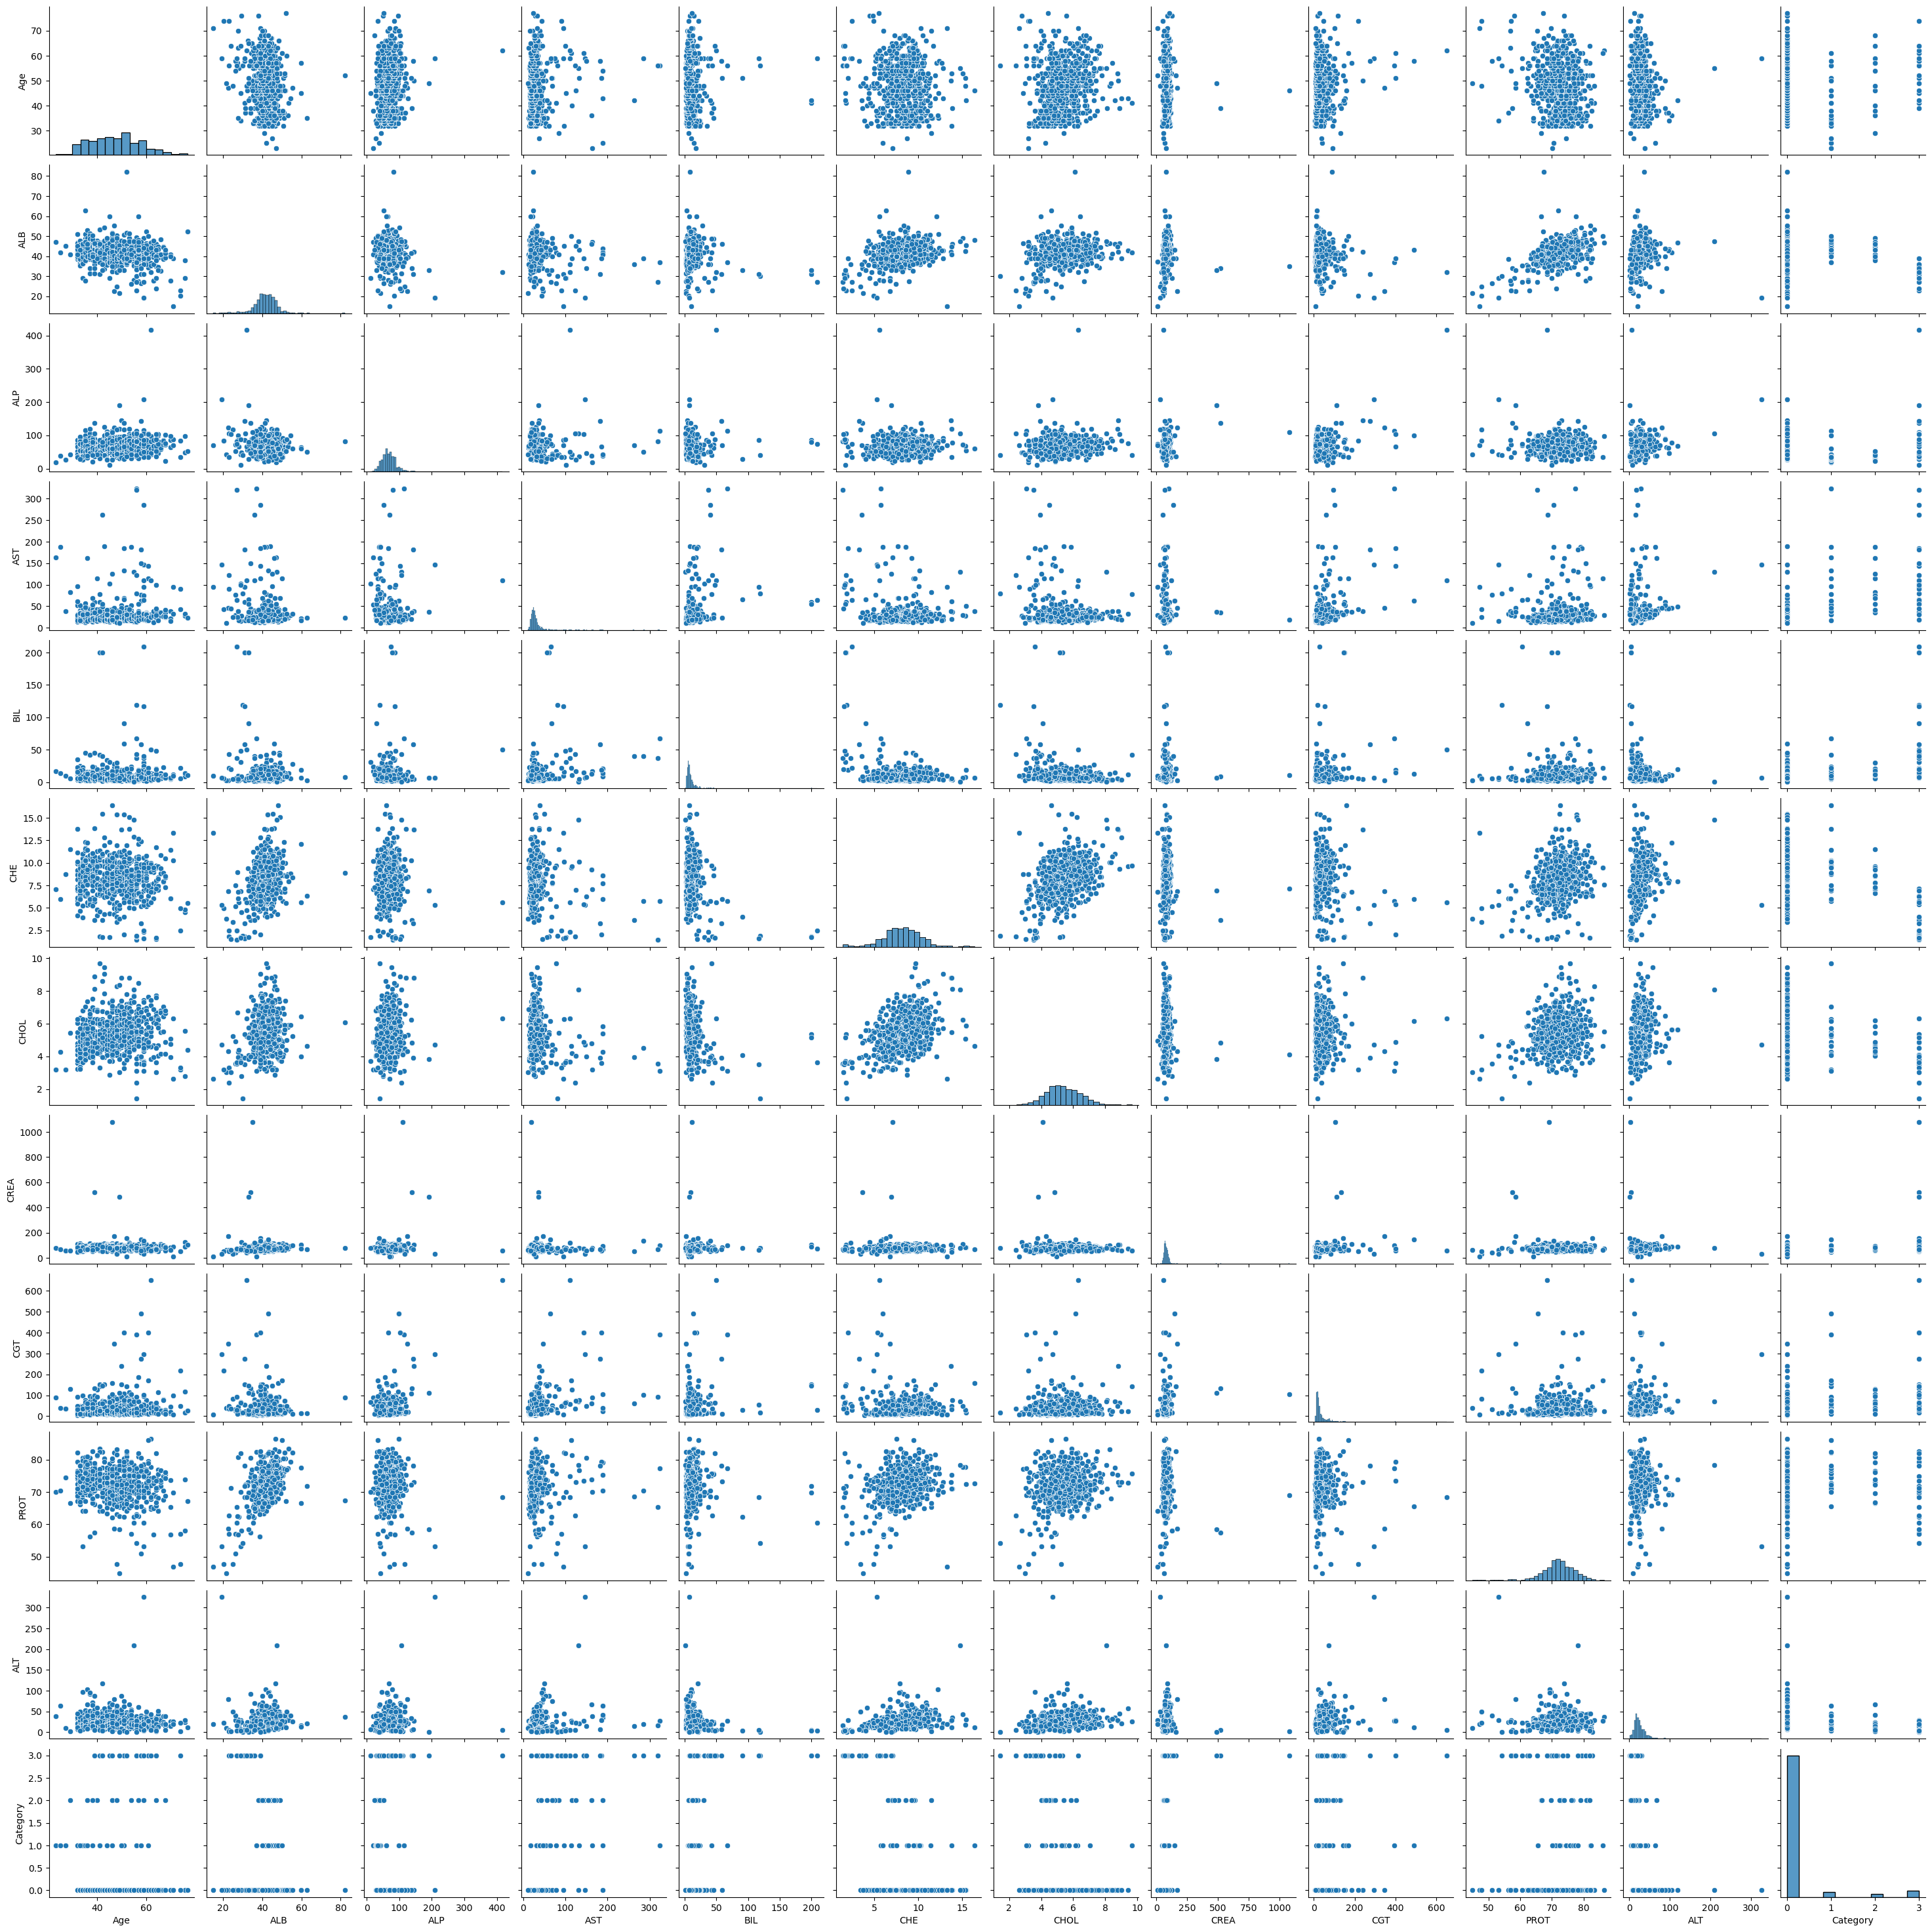

In [13]:
sns.pairplot(dataset_notNaN)

Algunas cosas a notar interesantes son la clara relación entre PROT y ALB, la proteína y albúmina, que son dos medidas de lo mismo pero en diferentes forma. Es posible que hubiera que descartar esta. Proteína con CHE y CHOL parecen tambiñen tener una ligera correlación entre ellas, y a su vez con la proteína y menos con la albúmina.

En cuanto a la relación con la categoría, lo más obvio parece que la proteína y la albúmina son más altas respecto a la población normal. Curiosamente sin embargo, vuelve a ser más baja en la fase de cirrosis. El factor CHE parece también más bajo en la fase de cirrosis, y la creatinina y la bilirrubina parece dinstitivamente más alta en la fase de cirrosis.

Vamos a valorar a continuación los histogramas por edad.

<Axes: xlabel='Age', ylabel='Count'>

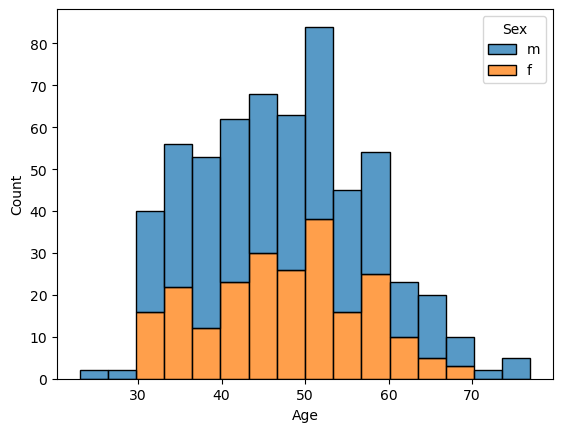

In [14]:
sns.histplot(dataset_notNaN, x='Age', hue = 'Sex', multiple='stack')

Hay valores extremos de edad, menos de 30 y más de 70, en los que además no hay población femenina. Los valores pareces extremo, y debido a la dispersión grande del conjunto, podría ser excesivamente sensible, por lo que podría ser conveniente eliminarlos.

In [15]:
numeric_cols = dataset_notNaN.columns.to_list()[2:-1]
print(numeric_cols)

['ALB', 'ALP', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'CGT', 'PROT', 'ALT']


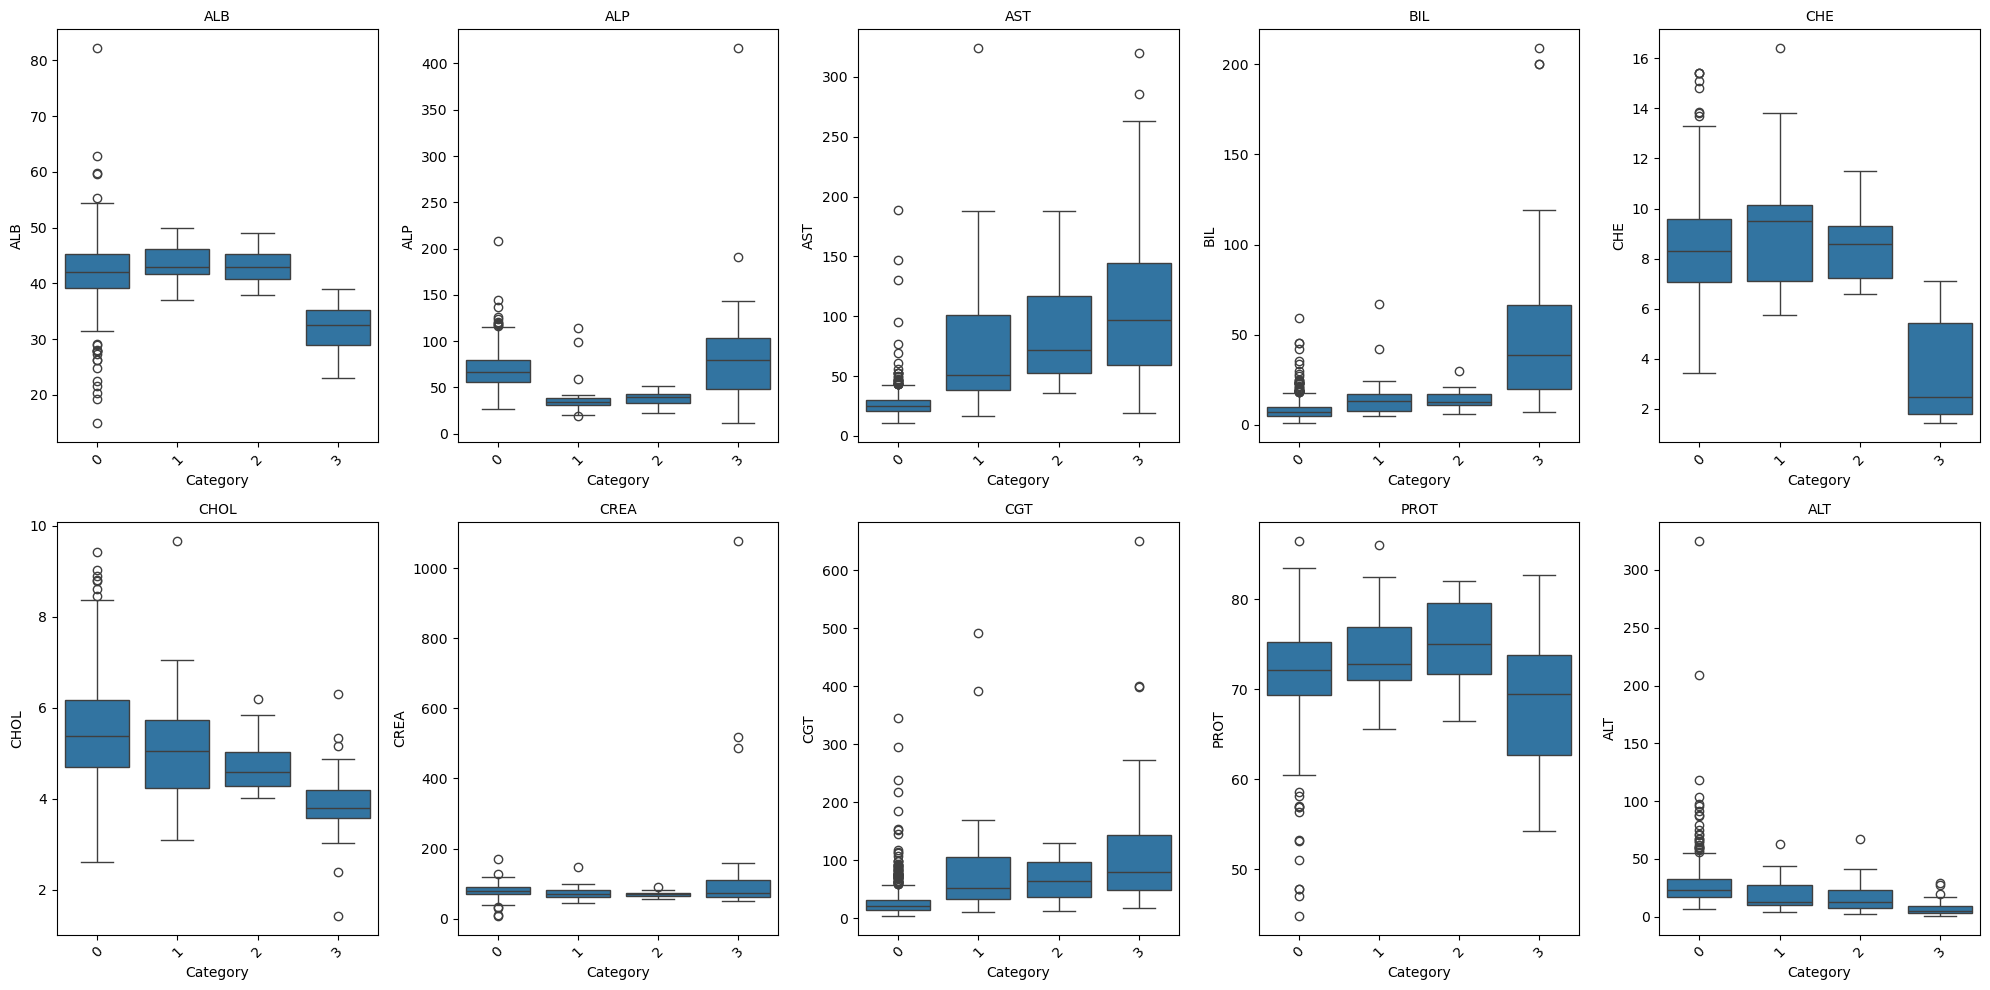

In [16]:
# Crear grid: ej. 2 filas x 5 columnas (10 plots)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, col in enumerate(numeric_cols):
    ax = axes[i//5, i%5]  # ubicar subplot
    sns.boxplot(data=dataset_notNaN, x='Category', y=col, ax=ax)
    ax.set_title(col, fontsize=10)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Aparecen outliers en varias categorías por cada variable numérica. Sin embargo en algunos casos parece haber incluso más datos de outliers en la categoría sin enfermedad que datos en cualquiera de las otras, por lo que por lo visto en el análisis descriptivo y el actual, no creo conveniente eliminar outliers para las variables continuas.

<a id="section13"></a>
## <font color="#004D7F"> 1.3. Análisis Exploratorio de los datos</font>

Ya hemos realizados las tareas que corresponden al análisis de nulos. Revisemos los duplicados, aunque en este caso como no hay indicadores de pacientes únicos (aunque se indique en la documentación del dataset no aparece en los datos que se han cargado), no puedo dilucidar si es un error o una muestra legítima de paciente y por ello creo que se debe incluir en el análisis que hemos hecho previamente, pero es relevante tenerlo en cuenta para valorar resultados.

In [17]:
print(len(dataset_notNaN)-len(dataset_notNaN.drop_duplicates()))

0


No hay por tanto registros duplicados.

Finalmente, el análisis de estos para tener en cuenta el preprocesamiento, tratamiento y elección de modelos serían:
- Problema de clasificación con 4 categorías.
- De las variables independientes tenemos dos demográficas: edad (numérica entero, en un rango de ) y sexo (categórica binaria, masculino o femenino), y el resto son 10 variables numéricas con rasgos diferenciados, sería relevante normalizar, si bien debido a la distribución dispersa otras transformaciones como centrar podría opacar nuestros datos de interés pues casi corresponden a outliers.
- Los datos son muy dispersos, puesto que las variables a identificar están muy desequilibradas y los datos de personas sana son extremadamente mayoritarios (533 de 589) frente a los que presentan algún grado de hepatitis. Es importante entonces tener en cuenta, según los modelos a seleccionar, la dispersión.
- Debido a que tenemos outliers importantes que no podemos librar y una matriz muy dispersa, la normalización es probable que debiera ser una técnica robusta basada en la media, de forma que que se ignore en el escalado.
- Hay más datos de hombres que de mujeres, sería importante revisar qué tal actúa la predicción para cada caso.
- El rango de edad mayoritario se encuentra entre 30 y 70 años, correspondiendo además exclusivamente al sexo masculino, en este caso si podríamos retirar los outliers pues podría opacar los resultados y asignar datos más incorrecto a hombres muy jóvenes o muy mayores. También sería importante tener en cuenta que entonces sólo es aplicable estas predicciones para personas entre 30 y 70 años. También deberíamos revisar de forma final el desglose de predicciones por edad.
- No hay registros duplicados.

---

<a id="section2"></a>
# <font color="#004D7F"> 2. Preprocesamiento y tratamiento de datos</font>

Con lo analizado en los anteriores resultados, lo que nos corresponde sería:
- Preprocesamiento de datos:
1. Codificar las variables categóricas, en este caso sólo Sex pues ya lo hicimos para la clase. Colocaremos 0 para f y 1 para m.
2. Eliminación de los outliers de edad, de menos de 30 años y más de 70 años.
3. Separación en training, validation y test.
4. Normalización robusta (por la presencia de outliers que no podemos eliminar) de los datos continuos no categóricos a 0-1, lo usaremos así por defecto y en caso de necesitar otras adaptaciones para modelos concretos lo incluiremos en la pipeline.  

- Feature Selection.
4. Valoraremos la correlación de cada variable con la clase a predecir, y entre sí mismaspara valorar si hay pares con mucha correlación.
5. Complementamos con Random Forest/Extra Trees para valorar la técnica. La idea es tener dos

<a id="section21"></a>
## <font color="#004D7F"> 2.1. Preprocesamiento de datos</font>

Codificación

<Axes: xlabel='Age', ylabel='Count'>

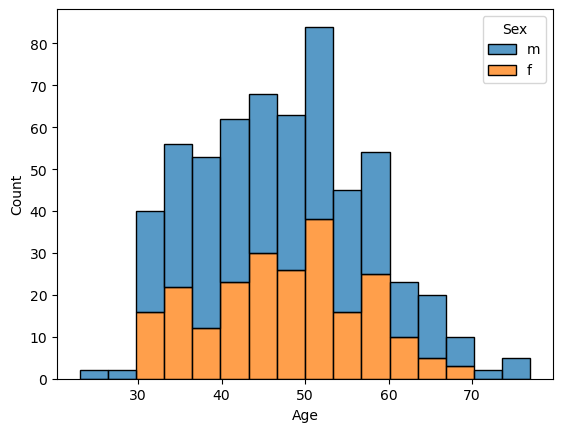

In [18]:
sns.histplot(dataset_notNaN, x='Age', hue = 'Sex', multiple='stack')

In [19]:
dataset_notNaN.loc[dataset_notNaN['Sex']=='f', 'Sex']= 0
dataset_notNaN.loc[dataset_notNaN['Sex']=='m', 'Sex']= 1

In [20]:
dataset_notNaN['Sex'] = dataset_notNaN['Sex'].astype(int)

In [21]:
dataset_notNaN.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589 entries, 0 to 612
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       589 non-null    int64  
 1   Sex       589 non-null    int64  
 2   ALB       589 non-null    float64
 3   ALP       589 non-null    float64
 4   AST       589 non-null    float64
 5   BIL       589 non-null    float64
 6   CHE       589 non-null    float64
 7   CHOL      589 non-null    float64
 8   CREA      589 non-null    float64
 9   CGT       589 non-null    float64
 10  PROT      589 non-null    float64
 11  ALT       589 non-null    float64
 12  Category  589 non-null    int64  
dtypes: float64(10), int64(3)
memory usage: 64.4 KB


In [22]:
dataset_notNaN.describe()

Age         Sex         ALB         ALP         AST         BIL  \
count  589.000000  589.000000  589.000000  589.000000  589.000000  589.000000   
mean    47.417657    0.616299   41.624278   68.123090   33.772835   11.018166   
std      9.931334    0.486700    5.761794   25.921072   32.866871   17.406572   
min     23.000000    0.000000   14.900000   11.300000   10.600000    0.800000   
25%     39.000000    0.000000   38.800000   52.500000   21.500000    5.200000   
50%     47.000000    1.000000   41.900000   66.200000   25.700000    7.100000   
75%     54.000000    1.000000   45.100000   79.900000   31.700000   11.000000   
max     77.000000    1.000000   82.200000  416.600000  324.000000  209.000000   

              CHE        CHOL         CREA         CGT        PROT  \
count  589.000000  589.000000   589.000000  589.000000  589.000000   
mean     8.203633    5.391341    81.669100   38.198472   71.890153   
std      2.191073    1.128954    50.696991   54.302407    5.348883   
min      1.420000    1.430000     8.000000    4.500000   44.800000   
25%      6.930000    4.620000    68.000000   15.600000   69.300000   
50%      8.260000    5.310000    77.000000   22.800000   72.100000   
75%      9.570000    6.080000    89.000000   37.600000   75.200000   
max     16.410000    9.670000  1079.100000  650.900000   86.500000   

              ALT    Category  
count  589.000000  589.000000  
mean    26.575382    0.196944  
std     20.863120    0.666439  
min      0.900000    0.000000  
25%     16.400000    0.000000  
50%     22.700000    0.000000  
75%     31.900000    0.000000  
max    325.300000    3.000000

Eliminación de outliers

In [23]:
dataset_notNaN = dataset_notNaN.loc[dataset_notNaN['Age']>=30]
dataset_notNaN = dataset_notNaN.loc[dataset_notNaN['Age']<70]

<Axes: xlabel='Age', ylabel='Count'>

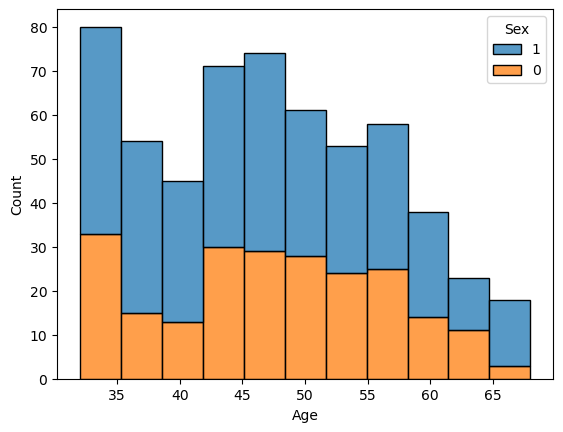

In [24]:
sns.histplot(dataset_notNaN.astype({'Sex':str}), x='Age', hue = 'Sex', multiple='stack')

Separación

In [25]:
X = dataset_notNaN[dataset_notNaN.columns.to_list()[:-1]]
y = dataset_notNaN[dataset_notNaN.columns.to_list()[-1]]

In [26]:
print(X.shape, y.shape)

(575, 12) (575,)


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=1/6, 
    stratify=y,
    random_state=21)
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, test_size=1/5, 
    stratify=Y_train,
    random_state=29)

In [28]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(383, 12) (383,)
(96, 12) (96,)
(96, 12) (96,)


In [29]:
print("Mínimo global:", np.min(X_train))
print("Máximo global:", np.max(X_train))
print("Mínimo global:", np.min(X_valid))
print("Máximo global:", np.max(X_valid))
print("Mínimo global:", np.min(X_test))
print("Máximo global:", np.max(X_test))

Mínimo global: 0.0
Máximo global: 1079.1
Mínimo global: 0.0
Máximo global: 491.0
Mínimo global: 0.0
Máximo global: 325.3


In [30]:
numeric_features = X_train.columns.to_list()
numeric_features.remove('Sex')
categorical_features = ['Sex'] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)
#hay que tener en cuenta que esto altera el orden de las columnas, y ahora las categóricas quedan al final
X_train_scaled = preprocessor.fit_transform(X_train)
X_valid_scaled = preprocessor.transform(X_valid)
X_test_scaled = preprocessor.transform(X_test)

In [31]:
print("Mínimo global:", np.min(X_train_scaled))
print("Máximo global:", np.max(X_train_scaled))
print("Mínimo global:", np.min(X_valid_scaled))
print("Máximo global:", np.max(X_valid_scaled))
print("Mínimo global:", np.min(X_test_scaled))
print("Máximo global:", np.max(X_test_scaled))

Mínimo global: -3.45
Máximo global: 50.105
Mínimo global: -3.8888888888888906
Máximo global: 24.710526315789473
Mínimo global: -4.365079365079367
Máximo global: 32.166666666666664


In [32]:
pd.DataFrame(X_train_scaled).describe()

0           1           2           3           4           5   \
count  383.000000  383.000000  383.000000  383.000000  383.000000  383.000000   
mean     0.032451   -0.037115    0.111742    0.742294    0.731462   -0.014355   
std      0.655825    0.890723    1.019942    3.300496    3.095756    0.862434   
min     -1.000000   -3.223140   -1.553506   -1.343284   -0.833333   -2.773663   
25%     -0.500000   -0.495868   -0.461255   -0.447761   -0.333333   -0.487654   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.500000    0.504132    0.538745    0.552239    0.666667    0.512346   
max      1.571429    6.644628   12.974170   29.701493   33.666667    3.395062   

               6           7           8           9           10          11  
count  383.000000  383.000000  383.000000  383.000000  383.000000  383.000000  
mean     0.060666    0.306162    0.803779   -0.031870    0.188248    0.618799  
std      0.768308    3.067889    2.988304    0.799278    1.008172    0.486317  
min     -2.708772   -3.450000   -0.894737   -3.380952   -1.458746    0.000000  
25%     -0.466667   -0.450000   -0.342105   -0.515873   -0.435644    0.000000  
50%      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000  
75%      0.533333    0.550000    0.657895    0.484127    0.564356    1.000000  
max      3.073684   50.105000   33.126316    2.174603    6.277228    1.000000

<a id="section21"></a>
## <font color="#004D7F"> 2.2. Tratamiento de datos/Feature Selection </font>

Correlación

In [33]:
list_corr = []
list_pvalue = []
feature_number = len(numeric_features) + len(categorical_features)
for i in range(feature_number):
    corr, p = scipy.stats.pearsonr(X_train_scaled[:,i], Y_train)
    corr = abs(corr)
    list_corr.append(corr)
    list_pvalue.append(p)

calc_data = pd.DataFrame([list_corr, list_pvalue],
             columns = numeric_features + categorical_features)

columns = ['correlaciones', 'p-value']
calc_data['Nombres'] = columns
calc_data = calc_data.set_index('Nombres')

In [34]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.float_format", "{:.8f}".format)

In [35]:
calc_data.sort_values(['correlaciones'], axis = 1, ascending = False)

AST        BIL        CGT        CHE       CREA  \
Nombres                                                                
correlaciones 0.63223338 0.57920963 0.49597826 0.37666362 0.30555000   
p-value       0.00000000 0.00000000 0.00000000 0.00000000 0.00000000   

                     ALB       CHOL        ALT        ALP        Age  \
Nombres                                                                
correlaciones 0.29558765 0.27141788 0.23036281 0.20959388 0.12253896   
p-value       0.00000000 0.00000007 0.00000524 0.00003558 0.01642444   

                    PROT        Sex  
Nombres                              
correlaciones 0.09446851 0.07195837  
p-value       0.06476535 0.15988082

A pesar de la correlación que vimos con aterioridad de Albúmina y Proteína, la proteína se rechaza como valor significativo. La proteína y el sexo no parecen tener datos relevantes, y ALP y edad tiene una relevancia mucho menos que el resto de variables también. Podremos valorar descartarlas dentro de la selección de features. Si bien hay que tener en cuenta que esto midel relaciones lineales mayoritariamente, pero obviamente obtendremos información más sencillamente del primer grupo. Si por ejemplo fuéramos a entrenar una regresión lineal, si sería conveniente descartarlas

Veamos ahora la correlación entre variables.

In [36]:
list_corr = []
list_pvalue = []
feature_number = len(numeric_features) + len(categorical_features)
features_names = numeric_features + categorical_features
list_features = []
for i in range(feature_number-1):
    var1 = X_train_scaled[:,i]
    features_names_1 = features_names[i]
    for j in range(feature_number-1-i):
        var2 = X_train_scaled[:,i+j+1]
        features_names_2 = features_names[i+j+1]
        corr, p = scipy.stats.pearsonr(var1, var2)
        corr = abs(corr)
        list_corr.append(corr)
        list_pvalue.append(p)
        list_features.append(features_names_1+' '+features_names_2)

calc_data_cross = pd.DataFrame([list_corr, list_pvalue],
             columns = list_features)

columns = ['correlaciones', 'p-value']
calc_data_cross['Nombres'] = columns
calc_data_cross = calc_data_cross.set_index('Nombres')

In [37]:
#mostramos sólo 20, sólo queremos los que tengan mayor correlación
calc_data_cross.sort_values(['correlaciones'], axis = 1, ascending = False).transpose().head(20)

Nombres    correlaciones    p-value
AST CGT       0.53245045 0.00000000
ALP CGT       0.52745512 0.00000000
ALB PROT      0.51749191 0.00000000
CHE CHOL      0.41077087 0.00000000
ALB CHE       0.35939719 0.00000000
CHE PROT      0.35378968 0.00000000
AST BIL       0.34396583 0.00000000
BIL CHE       0.34359182 0.00000000
CHE ALT       0.28120291 0.00000002
ALT Sex       0.25994549 0.00000025
AST CHE       0.24351858 0.00000141
CHOL PROT     0.24315574 0.00000147
ALB BIL       0.22798971 0.00000658
BIL CGT       0.22482334 0.00000889
AST CHOL      0.21647064 0.00001926
BIL CHOL      0.20351877 0.00006021
ALB CHOL      0.20251806 0.00006556
ALP CREA      0.19037879 0.00017829
ALB AST       0.18773631 0.00021991
Age CHOL      0.17116919 0.00076890

Vemos muy claramente la relación de albúmina y proteína. Aún más relevante parece la de ALP y CGT. Cómo la albúmina y la proteína parece que están relacionadas y además no hay relevancia para la proteína, creo que se puede descartar como variable.

Vamos ahora a utilizar Random Forest. Seguimos el tutorial de sklearn para ello:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_scaled, Y_train)

RandomForestClassifier(random_state=0)

Elapsed time to compute the importances: 0.013 seconds


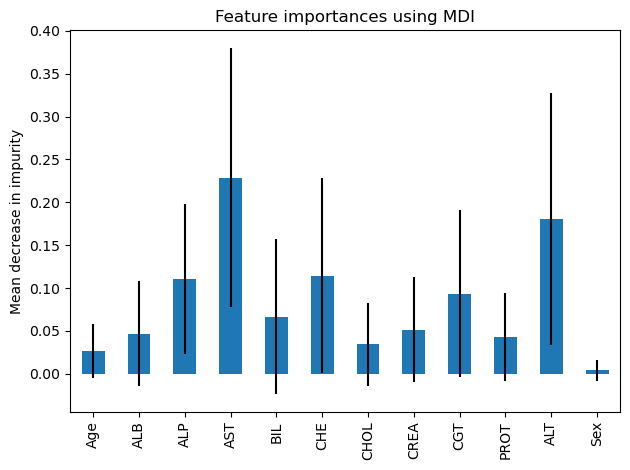

In [39]:
#impurity
import time

import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=features_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") #Mean Decrease in Impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Elapsed time to compute the importances: 1.361 seconds


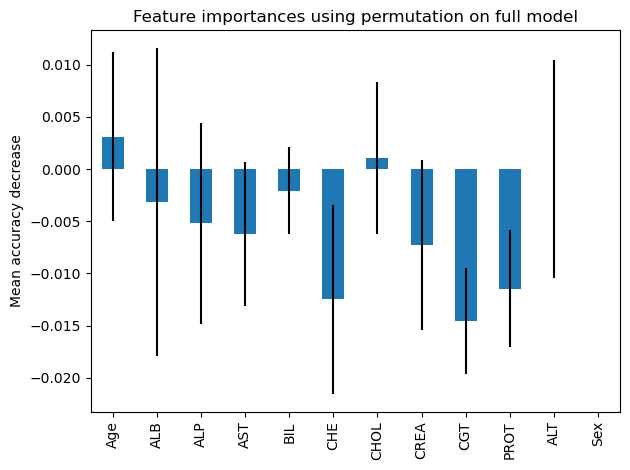

In [40]:
#feature permutation
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test_scaled, Y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=features_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Vemos que AST encaja también random forest como la variable más importante, con diferencia. Sex, Age y proteínas desaparecen totalmente en el de permutaciones, confirmado sospechas de baja relevancia. La bilirrubina desaparece en el random  forest, y ALT tiene gran diferencia entre ambos modelos de classifier. Uno mide impurezas y el otro permutaciones, es probable que las impurezas sean más sensibles a nuestros outliers. Por lo que parece es una enzima específica del hígado, por lo que sería algo diferencial en el diagnóstico específico de a cirrosis, pues AST puede ser producido por otros tejidos.

https://medlineplus.gov/spanish/pruebas-de-laboratorio/prueba-de-sangre-de-alt/

https://medlineplus.gov/spanish/ency/article/003472.htm

Puesto en que varias de las pruebas Sex, Age y PROT han denotado baja influencia en la categoría, las descartaría de selección final. El resto pueden aportar información y no las descartaría sin pruebas exhaustivas.


100


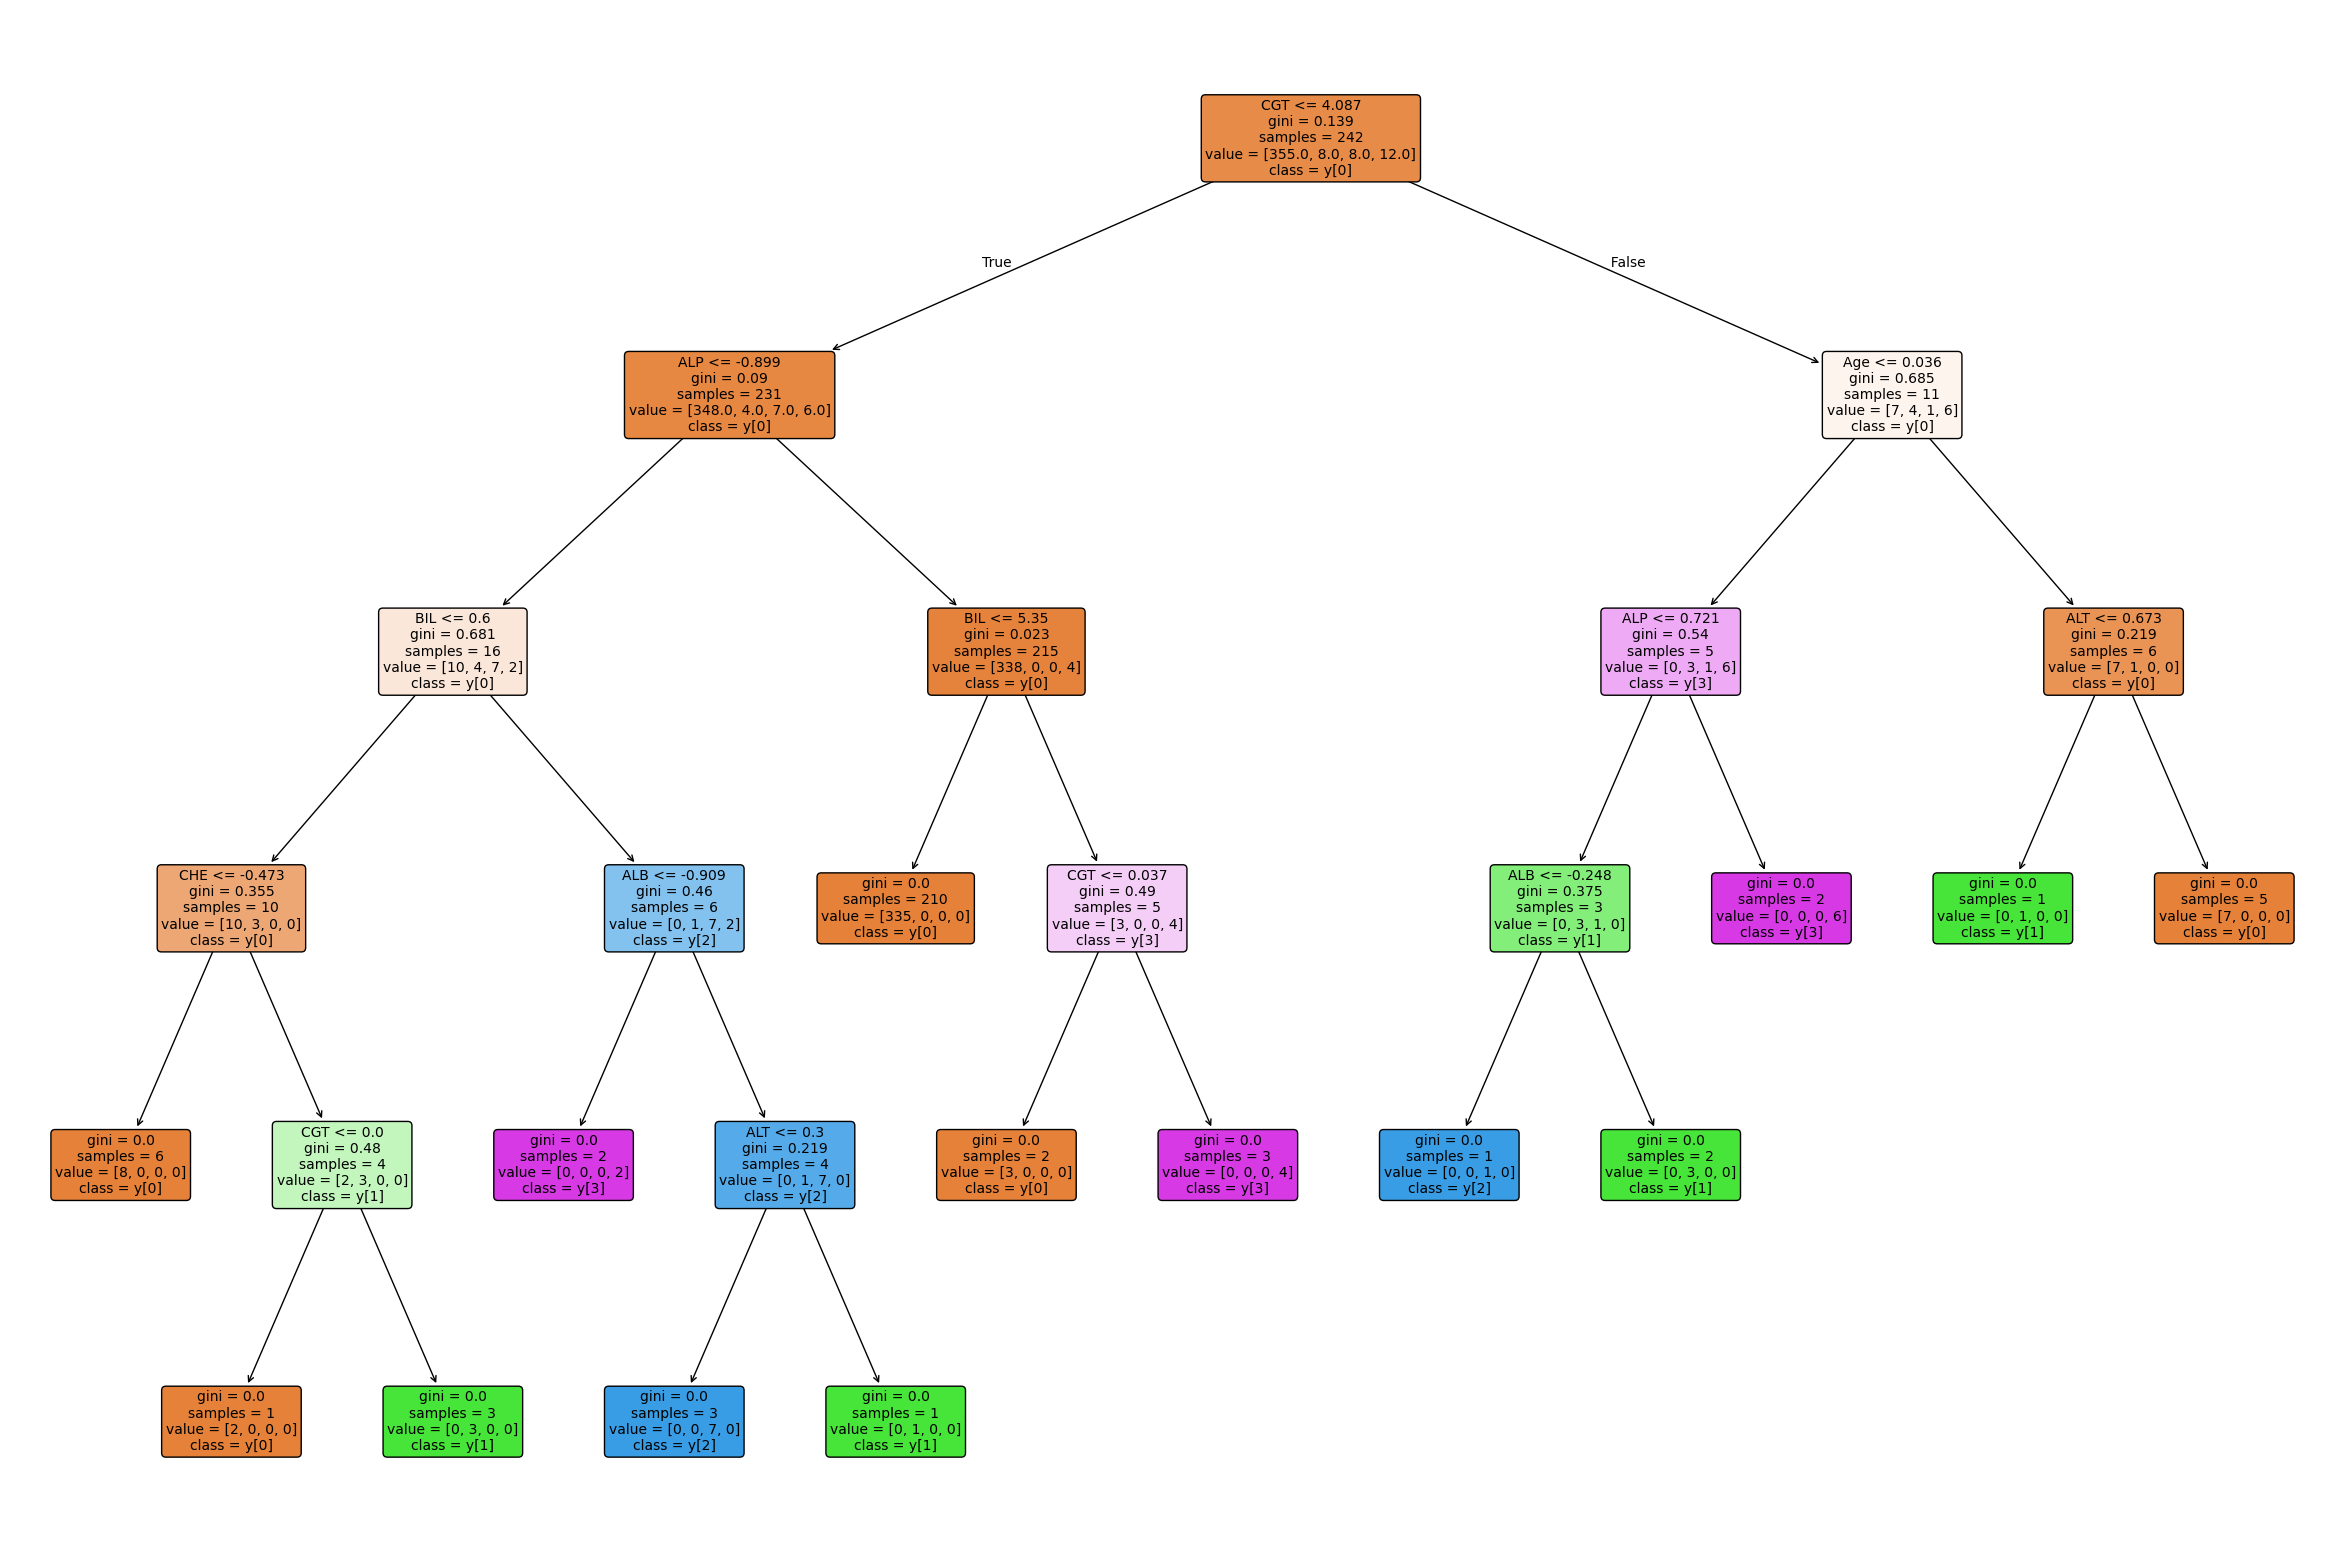

In [41]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Elegimos un árbol del bosque, por ejemplo el primero
print(len(forest.estimators_))
tree = forest.estimators_[0]

plt.figure(figsize=(30,20))
plot_tree(
    tree, 
    feature_names=features_names, 
    class_names=True,  
    filled=True,       
    rounded=True,     
    fontsize=10
)
plt.show()


En muchas de las raminificaciones vemos que hay ejemplos que son muy escasos, siendo 0 en muchos casos, pero esto puede estar dentro de lo esperado según nuestris anteriores análisis.

Intentaremos dibujar el proximity plot según lo indicado en este post:

https://stackoverflow.com/questions/18703136/proximity-matrix-in-sklearn-ensemble-randomforestclassifier

In [42]:
def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat  

In [43]:
proxMatrix = proximityMatrix(forest, X_train_scaled)

In [44]:
proxMatrix.shape

(383, 383)

In [45]:
from sklearn.manifold import MDS

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


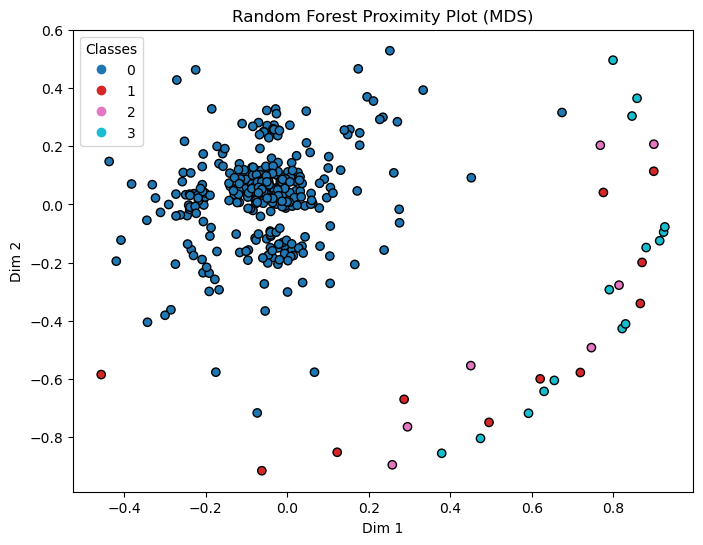

In [46]:
proxMatrix = proximityMatrix(forest, X_train_scaled)

distMat = 1 - proxMatrix  

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
X_mds = mds.fit_transform(distMat)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_mds[:,0], X_mds[:,1], c=Y_train, cmap="tab10", edgecolor="k")
plt.title("Random Forest Proximity Plot (MDS)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

Puede que sea por la dimensionalidad, pero no parece poderse hacer una buena distinción real entre los diferentes estadíos de daño hepático, si bien queda bien diferenciado.

In [47]:
features_remove = ['Age', 'PROT', 'Sex']
indices = [features_names.index(i) for i in features_remove]
X_train_scaled_skimmed = np.delete(X_train_scaled, indices, axis=1)
X_valid_scaled_skimmed = np.delete(X_valid_scaled, indices, axis=1)
X_test_scaled_skimmed = np.delete(X_test_scaled, indices, axis=1)

In [48]:
X_train_scaled_skimmed.shape

(383, 9)

In [49]:
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_valid, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([0, 1, 2, 3]), array([350,  11,   7,  15]))
(array([0, 1, 2, 3]), array([87,  3,  2,  4]))
(array([0, 1, 2, 3]), array([87,  3,  2,  4]))


---

<a id="section3"></a>
# <font color="#004D7F"> 3. Modelado de los datos</font>

En esta fase procederemos a utilizar varios modelos, con una inicialización básica, y de entre los mejores escogeremos los que optimizaremos.

Los modelos que hemos escogido para probar son:
1. Logistic regression (modelo lineal).
2. K-nn neighbours (basado en distancias).
3. Red neuronal (modelo no lineal, complejo). 
4. Random forest (ensemble bagging).
5. GradientBoostingClassifier (ensemble boosting).
6. DecisionTreeClassifier (modelo básico basad en árboles de decisión).
7. BaggingClassifier (usa un clasificador de de base y agrega, más general).
8. StackingClassifier (ensemble, mezcla clasificadores, agrega mejores modelos).
9. Voting Classifier (ensemble, mezcla clasificadores, vota mejores modelos).

Para medir, tendremos que ver por clase debido al desbalance.

In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#incialmente usaba todas las variables, pero no mostraban diferencias de rendimiento y siempre iban totalmente aparjeados los resultados.
def Classification_metrics(y_test, y_pred):
    # Calculate metrics for each class
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f_score = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy}") #exactitud
    print(f"Precision: {precision}") #precisión
    print(f"Recall: {recall}") #recordar...? evocar
    print(f"F-Score: {f_score}") 
    return accuracy, precision, recall, f_score

<a id="section31"></a>
## <font color="#004D7F"> 3.1. Modelado inicial </font>

### 1. Logistric Regression

In [51]:
#Clasificador lineal
from sklearn import linear_model #importamos el modelo
def Regresion(X_train, y_train, X_test):
    reg = linear_model.LogisticRegression(solver='liblinear', multi_class='ovr') #utilizamos un clasificador simple, ahora no nos interesa tanto usar un modelo adecuado tanto como evaluar si lo es

    #por lo general al ser un clasificador deberíamos codificar los valores categóricos, 
    #pero en los datos de dataset ya vienen con un valor asociado a cada clase
    reg.fit(X_train, y_train) #adaptamos modelo
    y_pred = reg.predict(X_test) #predecimos test
    return y_pred

In [52]:
repetitions = 4
list_names = []
list_metrics = []

In [53]:
for j in range(repetitions):
    Y_pred = Regresion(X_train_scaled_skimmed, Y_train, X_test_scaled_skimmed)
    print(len(Y_test), len(Y_pred))
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'LogisticRegression_run{}'.format(j)
    list_names.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)


96 96
Accuracy: 0.9791666666666666
Precision: 0.9610558712121212
Recall: 0.9791666666666666
F-Score: 0.9695238095238096


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0
96 96
Accuracy: 0.9791666666666666
Precision: 0.9610558712121212
Recall: 0.9791666666666666
F-Score: 0.9695238095238096


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0
96 96
Accuracy: 0.9791666666666666
Precision: 0.9610558712121212
Recall: 0.9791666666666666
F-Score: 0.9695238095238096


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


2 2
Accuracy: 0.0
Precision: 0.0
Re

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

En Cirrosis ha acertado algunas, pero es terrible para el resto con grados de hepatitis. Los resultados son malos en general.

In [54]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2          3
0  LogisticRegression_run0 1.00000000 1.00000000 0.00000000 1.00000000
1  LogisticRegression_run1 1.00000000 1.00000000 0.00000000 1.00000000
2  LogisticRegression_run2 1.00000000 1.00000000 0.00000000 1.00000000
3  LogisticRegression_run3 1.00000000 1.00000000 0.00000000 1.00000000

### 2. knn-neighbours

In [55]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [56]:
target_names = [0, 1, 2, 3]

In [57]:
def Knn_classification(X_train, y_train, n_neighbours):
    clf = Pipeline(steps=[
        ("knn", KNeighborsClassifier(n_neighbors=n_neighbours))
    ])
    clf.fit(X_train, y_train)
    return clf

def knn_plot(clf, y_train, X_train, X_test):
    # Creamos figura con dos subplots
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    #para visualizar aplicamos PCA
    scaler_PCA = Pipeline(steps=[
        ("pca", PCA(n_components=2))
    ])
    scaler_PCA.fit(X_train, y_train)
    X_train_pca = scaler_PCA.transform(X_train)
    X_test_pca = scaler_PCA.transform(X_test)

    for ax, weights in zip(axs, ("uniform", "distance")):
        #clf_vis.set_params(knn__weights=weights).fit(X_train_pca, y_train)
        #reentrenamos sólo para tener una visualización, no veremos el modelo exato pero sí una aproximación
        clf_vis = KNeighborsClassifier(n_neighbors=clf.named_steps["knn"].n_neighbors,
                                       weights=weights)
        clf_vis.fit(X_train_pca, y_train)
        disp = DecisionBoundaryDisplay.from_estimator(
            clf_vis,
            X_test_pca,  # importante: aquí pasamos X_test en dimensiones originales
            response_method="predict",
            plot_method="pcolormesh",
            xlabel="PS1",
            ylabel="PS2",
            shading="auto",
            alpha=0.3,
            ax=ax
        )

        scatter = ax.scatter(
            X_test_pca[:, 0], X_test_pca[:, 1], c=Y_test, edgecolors="k"#, cmap=disp.cmap
        )

        ax.legend(
            scatter.legend_elements()[0],
            target_names,
            loc="lower left",
            title="Classes"
        )

        ax.set_title(
            f"Hepatitis classification\n(k={clf.named_steps['knn'].n_neighbors}, weights={weights!r})"
        )

    plt.tight_layout()
    plt.show()
    return None

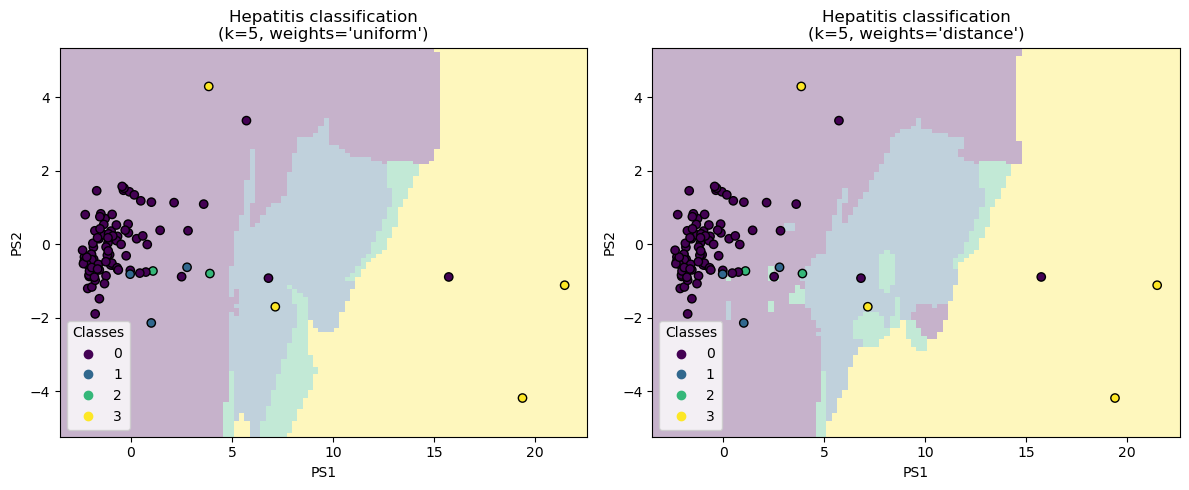

In [58]:
n_neighbours = 5
clf = Knn_classification(X_train_scaled_skimmed, Y_train, n_neighbours)
knn_plot(clf, Y_train, X_train_scaled_skimmed, X_test_scaled_skimmed)
Y_pred = clf.predict(X_test_scaled_skimmed)

In [59]:
for j in range(repetitions):
    n_neighbours = 3
    clf = Knn_classification(X_train_scaled_skimmed, Y_train, n_neighbours)
    #knn_plot(clf, Y_train, X_train_scaled_skimmed, X_test_scaled_skimmed)
    Y_pred = clf.predict(X_test_scaled_skimmed)
    print(len(Y_test), len(Y_pred))
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'Knn_run{}'.format(j)
    list_names.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)


96 96
Accuracy: 0.9375
Precision: 0.928125
Recall: 0.9375
F-Score: 0.9290842749529191


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666
96 96
Accuracy: 0.9375
Precision: 0.928125
Recall: 0.9375
F-Score: 0.9290842749529191


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666
96 96
Accuracy: 0.9375
Precision: 0.928125
Recall: 0.9375
F-Score: 0.9290842749529191


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

In [60]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2          3
0  LogisticRegression_run0 1.00000000 1.00000000 0.00000000 1.00000000
1  LogisticRegression_run1 1.00000000 1.00000000 0.00000000 1.00000000
2  LogisticRegression_run2 1.00000000 1.00000000 0.00000000 1.00000000
3  LogisticRegression_run3 1.00000000 1.00000000 0.00000000 1.00000000
4                 Knn_run0 1.00000000 0.00000000 0.50000000 0.50000000
5                 Knn_run1 1.00000000 0.00000000 0.50000000 0.50000000
6                 Knn_run2 1.00000000 0.00000000 0.50000000 0.50000000
7                 Knn_run3 1.00000000 0.00000000 0.50000000 0.50000000

No da mejores resultados, acierta alguna en la clase 2, pero ninguna en la 1 y a medias en la 3.

### 3. Red neuronal

Probaremos con unas redes neuronales sencillas

In [61]:
#definimos una clase para guardar los learning rates y usar callbacks para obtener los mejores parámetros
K = tf.keras.backend

# Callback personalizado
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.losses.append(logs.get("loss", None))

        # Obtener el valor de learning_rate y asegurarnos de que sea un número
        lr = self.model.optimizer.learning_rate
        #if not isinstance(lr, tf.Variable):
        #    lr = lr.numpy()  # Convertir a valor numérico si es un tf.Variable

        # Registrar la tasa de aprendizaje
        #self.rates.append(lr)
        self.rates.append(float(K.get_value(self.model.optimizer.learning_rate)))

        # Actualizar el learning rate
        if isinstance(float(K.get_value(self.model.optimizer.learning_rate)), (float, int)):
            new_lr = float(K.get_value(self.model.optimizer.learning_rate)) * self.factor
            self.model.optimizer.learning_rate.assign(new_lr)  # Modificar learning_rate

In [62]:
def plot_precision(history, directory, model_name):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Epoch')
    plt.ylabel('Precisión')
    plt.title('Precisión durante el entrenamiento, {}'.format(model_name))
    plt.legend()
    plt.grid(True)
    plt.savefig("{}/precision_entrenamiento_{}.png".format(directory, model_name), dpi=300)
    plt.close()  # para no mostrar en el notebook
    return None

In [63]:
def plot_loss_save(history, directory, best_epoch, best_values, model_name):
    loss = history.history["loss"]            # Pérdida en entrenamiento
    val_loss = history.history["val_loss"]    # Pérdida en validación

    epochs = range(1, len(loss) + 1)  # Lista de epochs

    # Graficar la pérdida
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, "b-", label="Training Loss")
    plt.plot(epochs, val_loss, "r--", label="Validation Loss")
    plt.plot(best_epoch, best_values[0], "p", label="Best Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Evolución de la función de pérdida, test accuracy best model {}".format(best_values[1]))
    plt.legend()
    
    plt.savefig("{}/loss_entrenamiento_{}.png".format(directory, model_name), dpi=300)
    plt.close()
    return None

In [64]:
def create_model( hidden_layers_neurons = [32, 64], value_learning_rate = 1e-3, growing_factor = 1.01, kernel_size = 3, num_features = 9):
    tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs

    inputs = tf.keras.Input((num_features,))
    x = inputs
        
    #x = keras.layers.Flatten()(x)
    for i in range(len(hidden_layers_neurons)):
        neurons = hidden_layers_neurons[i]
        x = keras.layers.Dense(neurons, activation = 'leaky_relu',
                            kernel_initializer="he_normal")(x)
        x = keras.layers.Dropout(0.5)(x)

    output = keras.layers.Dense(4, activation="softmax")(x) #categorización binaria
    
    model = keras.Model(inputs=inputs, outputs=output) 

    optimizer = tf.keras.optimizers.SGD(learning_rate = value_learning_rate)
    model.compile(loss = "sparse_categorical_crossentropy", 
                  optimizer = optimizer,
                  metrics = ["accuracy"])
    expon_lr = ExponentialLearningRate(factor = growing_factor)
    return model, expon_lr

In [65]:
dense_layers = [64, 64, 64]
value_lr = 1e-1
gr_factor = 1.005
augmentation = False
model, expon_lr = create_model(hidden_layers_neurons = dense_layers, 
                               value_learning_rate = value_lr, 
                               growing_factor = gr_factor)

I0000 00:00:1756723809.101835  609609 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:0b:00.0, compute capability: 8.9


In [66]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,220 (36.02 KB)

 Trainable params: 9,220 (36.02 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
history = model.fit(X_train_scaled_skimmed, Y_train, epochs=1,
                    validation_data=(X_valid_scaled_skimmed, Y_valid),
                    callbacks=[expon_lr])

I0000 00:00:1756723810.199433  609790 service.cc:148] XLA service 0x7e4d5c004690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756723810.199482  609790 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-09-01 11:50:10.226624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756723810.255844  609790 cuda_dnn.cc:529] Loaded cuDNN version 91001


 1/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0625 - loss: 9.9079

I0000 00:00:1756723811.772334  609790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.5278 - loss: 5.0051 - val_accuracy: 0.6771 - val_loss: 1.1553


Text(0, 0.5, 'Loss')

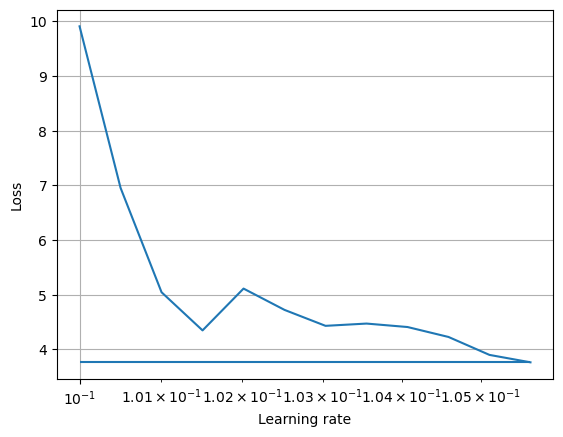

In [68]:
#visualizamos la función de loss según el learning rate
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
#plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [69]:
os.makedirs('Modelo_RedNeuronal_1', exist_ok=True)

In [70]:
for i in range(repetitions):
    inicio = time.time()

    name_directory = 'Modelo_RedNeuronal_1'
    name_model = "Modelo_RedNeuronal_1/bestModel.keras"

    value_lr = 1.1e-1
    val_patience = 5
    batch_size = 32

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = val_patience) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(name_model, save_best_only=True) #me quedo el mejor y bye lo demás

    model, expon_lr = create_model(
                                hidden_layers_neurons = dense_layers, 
                                value_learning_rate = value_lr, 
                                growing_factor = gr_factor)
    history = model.fit(X_train_scaled_skimmed, Y_train, 
                        validation_data=(X_valid_scaled_skimmed, Y_valid), 
                        epochs=100, 
                        batch_size = batch_size, 
                        callbacks = [early_stopping_cb, checkpoint_cb])

    model = tf.keras.models.load_model(name_model) # rollback to best model

    score = model.evaluate(X_test_scaled_skimmed, Y_test) #testeamos qué tal queda
    Y_pred = model.predict(X_test_scaled_skimmed)
    Y_pred = np.argmax(Y_pred, axis=1)

    best_epoch = early_stopping_cb.stopped_epoch - early_stopping_cb.patience + 1

    fin = time.time()
    seconds = fin-inicio

    model_name = "Modelo_RedNeuronal_1_bestModel_run{}".format(i)

    #plot_loss_save(expon_lr, best_epoch, name_directory)
    plot_loss_save(history, name_directory, best_epoch, score, model_name)
    plot_precision(history, name_directory, model_name)

    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    list_names.append(model_name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.4683 - loss: 4.8695 - val_accuracy: 0.9271 - val_loss: 1.4674
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 7.6894 - val_accuracy: 0.9271 - val_loss: 0.3917
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8744 - loss: 1.1276 - val_accuracy: 0.9062 - val_loss: 0.4990
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7991 - loss: 0.9583 - val_accuracy: 0.9479 - val_loss: 0.2261
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8618 - loss: 0.8835 - val_accuracy: 0.9479 - val_loss: 0.2892
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9126 - loss: 0.5691 - val_accuracy: 0.9375 - val_loss: 0.4340
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9255 - loss: 1.2070 - val_accuracy: 0.9375 - val_loss: 0.4655
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8638 - loss: 1.2321 - val_accuracy: 0.9375 -

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Accuracy: 0.9791666666666666
Precision: 0.9666666666666667
Recall: 0.9791666666666666
F-Score: 0.9713541666666666


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5520 - loss: 5.3566 - val_accuracy: 0.8229 - val_loss: 1.0672
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7462 - loss: 3.6642 - val_accuracy: 0.9375 - val_loss: 0.3734
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7824 - loss: 1.9358 - val_accuracy: 0.9271 - val_loss: 0.5503
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8337 - loss: 1.7098 - val_accuracy: 0.9375 - val_loss: 0.6344
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7746 - loss: 2.0607 - val_accuracy: 0.9375 - val_loss: 0.4703
Epoch 6

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.5636 - loss: 4.2570 - val_accuracy: 0.9375 - val_loss: 0.6837
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8127 - loss: 1.5919 - val_accuracy: 0.9271 - val_loss: 0.3530
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8444 - loss: 1.6054 - val_accuracy: 0.9479 - val_loss: 0.3009
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8939 - loss: 1.2144 - val_accuracy: 0.9375 - val_loss: 0.3394
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8571 - loss: 0.8004 - val_accuracy: 0.9479 - val_loss: 0.2069
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8941 - loss: 0.8514 - val_accuracy: 0.9479 - val_loss: 0.2246
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9284 - loss: 0.4317 - val_accuracy: 0.9583 - val_loss: 0.1917
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9317 - loss: 0.4821 - val_accuracy: 0.93

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Accuracy: 0.9270833333333334
Precision: 0.9239583333333332
Recall: 0.9270833333333334
F-Score: 0.9153689971751412


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.25
Precision: 1.0
Recall: 0.25
F-Score: 0.4
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.4592 - loss: 7.2742 - val_accuracy: 0.9479 - val_loss: 0.5156
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8101 - loss: 1.9357 - val_accuracy: 0.9167 - val_loss: 0.5111
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8203 - loss: 2.0148 - val_accuracy: 0.9583 - val_loss: 0.1750
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8581 - loss: 0.8817 - val_accuracy: 0.9375 - val_loss: 0.2125
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9010 - loss: 0.9064 - val_accuracy: 

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [71]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2  \
0               LogisticRegression_run0 1.00000000 1.00000000 0.00000000   
1               LogisticRegression_run1 1.00000000 1.00000000 0.00000000   
2               LogisticRegression_run2 1.00000000 1.00000000 0.00000000   
3               LogisticRegression_run3 1.00000000 1.00000000 0.00000000   
4                              Knn_run0 1.00000000 0.00000000 0.50000000   
5                              Knn_run1 1.00000000 0.00000000 0.50000000   
6                              Knn_run2 1.00000000 0.00000000 0.50000000   
7                              Knn_run3 1.00000000 0.00000000 0.50000000   
8   Modelo_RedNeuronal_1_bestModel_run0 1.00000000 1.00000000 0.00000000   
9   Modelo_RedNeuronal_1_bestModel_run1 1.00000000 0.33333333 0.50000000   
10  Modelo_RedNeuronal_1_bestModel_run2 1.00000000 0.33333333 0.00000000   
11  Modelo_RedNeuronal_1_bestModel_run3 0.98850575 0.00000000 0.00000000   

            3  
0  1.00000000  
1  1.00000000  
2  1.00000000  
3  1.00000000  
4  0.50000000  
5  0.50000000  
6  0.50000000  
7  0.50000000  
8  1.00000000  
9  0.50000000  
10 0.25000000  
11 1.00000000

Las red neuronal ha fallado un poco más en todos, no ha acertado ninguna de la clase 1 pero sí la clase 2 y 3.

Vamos a observar las gráficas de sólo una de las ejecuciones, pero en general todas parecen converger convenientemente en loss y exactitud.

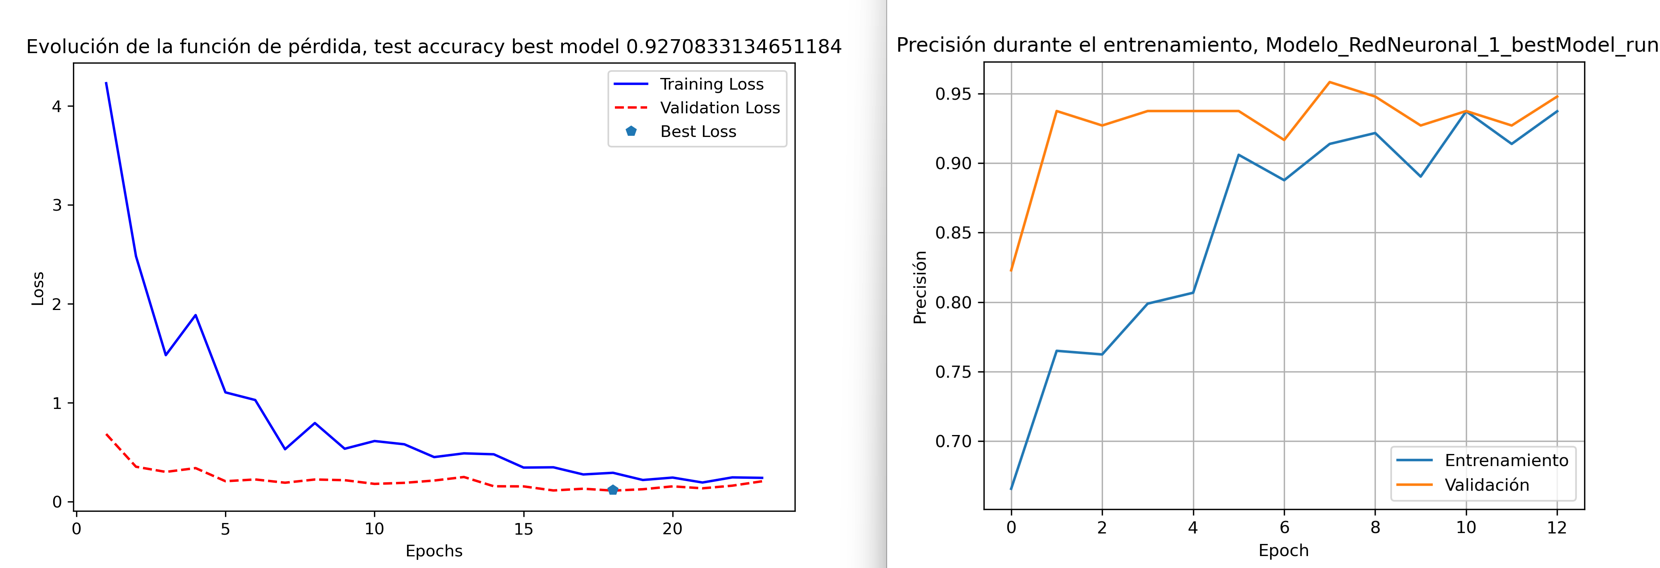


### 4. Random Forest

Vamos ahora a probar el clasificador. En la parte de selección de características observamos que predecía bien las características de mayor relevancia, por lo que deberíamos esperar buenos resultados.

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
for j in range(repetitions):
    forest = RandomForestClassifier(random_state=33, 
                                    #class_weight='balanced'
                                    )
    forest.fit(X_train_scaled_skimmed, Y_train)
    Y_pred = forest.predict(X_test_scaled_skimmed)
    print(len(Y_test), len(Y_pred))
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'RandomForest_run{}'.format(j)
    list_names.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

96 96
Accuracy: 0.9166666666666666
Precision: 0.8967696629213483
Recall: 0.9166666666666666
F-Score: 0.9066051136363636


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571
96 96
Accuracy: 0.9166666666666666
Precision: 0.8967696629213483
Recall: 0.9166666666666666
F-Score: 0.9066051136363636


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

96 96
Accuracy: 0.9166666666666666
Precision: 0.8967696629213483
Recall: 0.9166666666666666
F-Score: 0.9066051136363636


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

96 96
Accuracy: 0.9166666666666666
Precision: 0.8967696629213483
Recall: 0.9166666666666666
F-Score: 0.9066051136363636


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [74]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2  \
0               LogisticRegression_run0 1.00000000 1.00000000 0.00000000   
1               LogisticRegression_run1 1.00000000 1.00000000 0.00000000   
2               LogisticRegression_run2 1.00000000 1.00000000 0.00000000   
3               LogisticRegression_run3 1.00000000 1.00000000 0.00000000   
4                              Knn_run0 1.00000000 0.00000000 0.50000000   
5                              Knn_run1 1.00000000 0.00000000 0.50000000   
6                              Knn_run2 1.00000000 0.00000000 0.50000000   
7                              Knn_run3 1.00000000 0.00000000 0.50000000   
8   Modelo_RedNeuronal_1_bestModel_run0 1.00000000 1.00000000 0.00000000   
9   Modelo_RedNeuronal_1_bestModel_run1 1.00000000 0.33333333 0.50000000   
10  Modelo_RedNeuronal_1_bestModel_run2 1.00000000 0.33333333 0.00000000   
11  Modelo_RedNeuronal_1_bestModel_run3 0.98850575 0.00000000 0.00000000   
12                    RandomForest_run0 0.97701149 0.00000000 0.00000000   
13                    RandomForest_run1 0.97701149 0.00000000 0.00000000   
14                    RandomForest_run2 0.97701149 0.00000000 0.00000000   
15                    RandomForest_run3 0.97701149 0.00000000 0.00000000   

            3  
0  1.00000000  
1  1.00000000  
2  1.00000000  
3  1.00000000  
4  0.50000000  
5  0.50000000  
6  0.50000000  
7  0.50000000  
8  1.00000000  
9  0.50000000  
10 0.25000000  
11 1.00000000  
12 0.75000000  
13 0.75000000  
14 0.75000000  
15 0.75000000

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


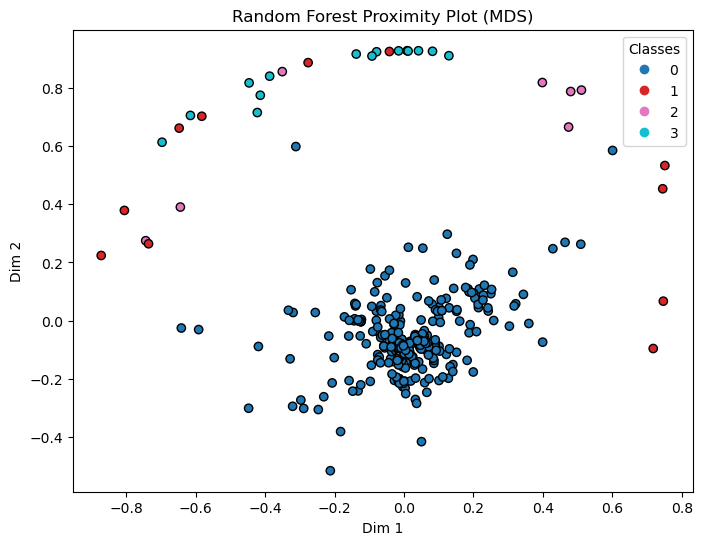

In [75]:
# se debe tener en cuenta que sólo vemos el plot de la última ejecución
proxMatrix = proximityMatrix(forest, X_train_scaled_skimmed)

distMat = 1 - proxMatrix  

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
X_mds = mds.fit_transform(distMat)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_mds[:,0], X_mds[:,1], c=Y_train, cmap="tab10", edgecolor="k")
plt.title("Random Forest Proximity Plot (MDS)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

Random Forest no mejora los resultados anteriores, quizás sean tan pocos valores que incluso puede estar exhibiendo un comportamiento determinista según los criterios que estamos usando. 

### 5. Gradient Boosting Classifier

Este método se basa en boosting, es decir, en construir un modelo de forma secuencial, donde cada nuevo estimador intenta corregir los errores de los anteriores.
En particular, Gradient Boosting entrena en cada iteración un árbol de regresión sobre el gradiente negativo de la función de pérdida (que indica la dirección en la que el modelo actual debe mejorar). Estas iteraciones se van acumulando generando un modelo aditivo.

Se diferencia en random forest en que utiliza la guía del gradiente en vez de añadir instancias aleatorias.

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

In [77]:
for j in range(repetitions):
    GBC = GradientBoostingClassifier(random_state=42)
    GBC.fit(X_train_scaled_skimmed, Y_train)
    Y_pred = GBC.predict(X_test_scaled_skimmed)
    print(len(Y_test), len(Y_pred))
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'GradientBoostingClassifier_run{}'.format(j)
    list_names.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)

96 96
Accuracy: 0.9583333333333334
Precision: 0.9635416666666666
Recall: 0.9583333333333334
F-Score: 0.9598214285714285


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

96 96
Accuracy: 0.9583333333333334
Precision: 0.9635416666666666
Recall: 0.9583333333333334
F-Score: 0.9598214285714285


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

96 96
Accuracy: 0.9583333333333334
Precision: 0.9635416666666666
Recall: 0.9583333333333334
F-Score: 0.9598214285714285


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

96 96
Accuracy: 0.9583333333333334
Precision: 0.9635416666666666
Recall: 0.9583333333333334
F-Score: 0.9598214285714285


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

In [78]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2  \
0               LogisticRegression_run0 1.00000000 1.00000000 0.00000000   
1               LogisticRegression_run1 1.00000000 1.00000000 0.00000000   
2               LogisticRegression_run2 1.00000000 1.00000000 0.00000000   
3               LogisticRegression_run3 1.00000000 1.00000000 0.00000000   
4                              Knn_run0 1.00000000 0.00000000 0.50000000   
5                              Knn_run1 1.00000000 0.00000000 0.50000000   
6                              Knn_run2 1.00000000 0.00000000 0.50000000   
7                              Knn_run3 1.00000000 0.00000000 0.50000000   
8   Modelo_RedNeuronal_1_bestModel_run0 1.00000000 1.00000000 0.00000000   
9   Modelo_RedNeuronal_1_bestModel_run1 1.00000000 0.33333333 0.50000000   
10  Modelo_RedNeuronal_1_bestModel_run2 1.00000000 0.33333333 0.00000000   
11  Modelo_RedNeuronal_1_bestModel_run3 0.98850575 0.00000000 0.00000000   
12                    RandomForest_run0 0.97701149 0.00000000 0.00000000   
13                    RandomForest_run1 0.97701149 0.00000000 0.00000000   
14                    RandomForest_run2 0.97701149 0.00000000 0.00000000   
15                    RandomForest_run3 0.97701149 0.00000000 0.00000000   
16      GradientBoostingClassifier_run0 1.00000000 0.66666667 0.00000000   
17      GradientBoostingClassifier_run1 1.00000000 0.66666667 0.00000000   
18      GradientBoostingClassifier_run2 1.00000000 0.66666667 0.00000000   
19      GradientBoostingClassifier_run3 1.00000000 0.66666667 0.00000000   

            3  
0  1.00000000  
1  1.00000000  
2  1.00000000  
3  1.00000000  
4  0.50000000  
5  0.50000000  
6  0.50000000  
7  0.50000000  
8  1.00000000  
9  0.50000000  
10 0.25000000  
11 1.00000000  
12 0.75000000  
13 0.75000000  
14 0.75000000  
15 0.75000000  
16 0.75000000  
17 0.75000000  
18 0.75000000  
19 0.75000000

Tampoco es que sea mucho mejor, sigue sin acertar ninguna en la clase 2.

### 6. DecisionTreeClassifier

Este es un clasificador sencillo de un solo árbol (un modelo de aprendizaje supervisado, jerárquico) que hace separaciones de forma determinista según el criterio escogido (gini habitualmente). Es una implementación sencilla de "divide an conquer", pero buscando que los grupos finales de una rama sean lo más homogéneos posibles. Probamos para poder comparar su clasificación con técnicas similares pero de inicialización aleatoria y estadística como random forest, que en principio prouce resultados más robustos con menor varianza al promediar con varios árboles.

In [79]:
from sklearn.tree import DecisionTreeClassifier

In [80]:
for j in range(repetitions):
    DTC = DecisionTreeClassifier(random_state=42)
    DTC.fit(X_train_scaled_skimmed, Y_train)
    Y_pred = DTC.predict(X_test_scaled_skimmed)
    print(len(Y_test), len(Y_pred))
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'DecisionTreeClassifier_run{}'.format(j)
    list_names.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)

96 96
Accuracy: 0.9270833333333334
Precision: 0.9546160130718956
Recall: 0.9270833333333334
F-Score: 0.9337855297157622


0 87
Accuracy: 0.9655172413793104
Precision: 1.0
Recall: 0.9655172413793104
F-Score: 0.9824561403508771


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


3 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666
96 96
Accuracy: 0.9270833333333334
Precision: 0.9546160130718956
Recall: 0.9270833333333334
F-Score: 0.9337855297157622


0 87
Accuracy: 0.9655172413793104
Precision: 1.0
Recall: 0.9655172413793104
F-Score: 0.9824561403508771


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


3 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666
96 96
Accuracy: 0.9270833333333334
Precision: 0.9546160130718956
Recall: 0.9270833333333334
F-Scor

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [81]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2  \
0               LogisticRegression_run0 1.00000000 1.00000000 0.00000000   
1               LogisticRegression_run1 1.00000000 1.00000000 0.00000000   
2               LogisticRegression_run2 1.00000000 1.00000000 0.00000000   
3               LogisticRegression_run3 1.00000000 1.00000000 0.00000000   
4                              Knn_run0 1.00000000 0.00000000 0.50000000   
5                              Knn_run1 1.00000000 0.00000000 0.50000000   
6                              Knn_run2 1.00000000 0.00000000 0.50000000   
7                              Knn_run3 1.00000000 0.00000000 0.50000000   
8   Modelo_RedNeuronal_1_bestModel_run0 1.00000000 1.00000000 0.00000000   
9   Modelo_RedNeuronal_1_bestModel_run1 1.00000000 0.33333333 0.50000000   
10  Modelo_RedNeuronal_1_bestModel_run2 1.00000000 0.33333333 0.00000000   
11  Modelo_RedNeuronal_1_bestModel_run3 0.98850575 0.00000000 0.00000000   
12                    RandomForest_run0 0.97701149 0.00000000 0.00000000   
13                    RandomForest_run1 0.97701149 0.00000000 0.00000000   
14                    RandomForest_run2 0.97701149 0.00000000 0.00000000   
15                    RandomForest_run3 0.97701149 0.00000000 0.00000000   
16      GradientBoostingClassifier_run0 1.00000000 0.66666667 0.00000000   
17      GradientBoostingClassifier_run1 1.00000000 0.66666667 0.00000000   
18      GradientBoostingClassifier_run2 1.00000000 0.66666667 0.00000000   
19      GradientBoostingClassifier_run3 1.00000000 0.66666667 0.00000000   
20          DecisionTreeClassifier_run0 0.96551724 0.33333333 1.00000000   
21          DecisionTreeClassifier_run1 0.96551724 0.33333333 1.00000000   
22          DecisionTreeClassifier_run2 0.96551724 0.33333333 1.00000000   
23          DecisionTreeClassifier_run3 0.96551724 0.33333333 1.00000000   

            3  
0  1.00000000  
1  1.00000000  
2  1.00000000  
3  1.00000000  
4  0.50000000  
5  0.50000000  
6  0.50000000  
7  0.50000000  
8  1.00000000  
9  0.50000000  
10 0.25000000  
11 1.00000000  
12 0.75000000  
13 0.75000000  
14 0.75000000  
15 0.75000000  
16 0.75000000  
17 0.75000000  
18 0.75000000  
19 0.75000000  
20 0.50000000  
21 0.50000000  
22 0.50000000  
23 0.50000000

Es por ahora el mejor resultado, ya que al menos presenta aciertos en todas las clases.

### 7. Bagging Classifier

In [82]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

In [83]:
#esto fue una prueba para ver estimadores disponibles en sklearn, para utilizar otros con el Baggin Classifier general
#i = 20
#sklearn.utils.discovery.all_estimators()[10+i:30+i]

In [84]:
estimators = [DecisionTreeClassifier(), SVC(probability=True), LogisticRegression(), sklearn.tree._classes.ExtraTreeClassifier(), sklearn.naive_bayes.GaussianNB()]
for j, estimator in enumerate(estimators):
    clf = BaggingClassifier(estimator=estimator,
                        n_estimators=20, random_state=55).fit(X_train_scaled_skimmed, Y_train)
    Y_pred = clf.predict(X_test_scaled_skimmed)
    print(len(Y_test), len(Y_pred))
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'BaggingClassifier_{}_run{}'.format(str(estimator), j)
    list_names.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)

96 96
Accuracy: 0.9375
Precision: 0.947671568627451
Recall: 0.9375
F-Score: 0.9407299741602065


0 87
Accuracy: 0.9655172413793104
Precision: 1.0
Recall: 0.9655172413793104
F-Score: 0.9824561403508771


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

96 96
Accuracy: 0.9270833333333334
Precision: 0.9118134469696969
Recall: 0.9270833333333334
F-Score: 0.919047619047619


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

96 96
Accuracy: 0.9791666666666666
Precision: 0.9666666666666667
Recall: 0.9791666666666666
F-Score: 0.9713541666666666


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0
96 96
Accuracy: 0.9375
Precision: 0.9128472222222223
Recall: 0.9375
F-Score: 0.9243997175141243


0 87
Accuracy: 0.9885057471264368
Precision: 1.0
Recall: 0.9885057471264368
F-Score: 0.9942196531791907


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571
96 96
Accuracy: 0.9479166666666666
Precision: 0.9395833333333333
Recall: 0.9479166666666666
F-Score: 0.9427083333333334


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

In [85]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1  \
0                           LogisticRegression_run0 1.00000000 1.00000000   
1                           LogisticRegression_run1 1.00000000 1.00000000   
2                           LogisticRegression_run2 1.00000000 1.00000000   
3                           LogisticRegression_run3 1.00000000 1.00000000   
4                                          Knn_run0 1.00000000 0.00000000   
5                                          Knn_run1 1.00000000 0.00000000   
6                                          Knn_run2 1.00000000 0.00000000   
7                                          Knn_run3 1.00000000 0.00000000   
8               Modelo_RedNeuronal_1_bestModel_run0 1.00000000 1.00000000   
9               Modelo_RedNeuronal_1_bestModel_run1 1.00000000 0.33333333   
10              Modelo_RedNeuronal_1_bestModel_run2 1.00000000 0.33333333   
11              Modelo_RedNeuronal_1_bestModel_run3 0.98850575 0.00000000   
12                                RandomForest_run0 0.97701149 0.00000000   
13                                RandomForest_run1 0.97701149 0.00000000   
14                                RandomForest_run2 0.97701149 0.00000000   
15                                RandomForest_run3 0.97701149 0.00000000   
16                  GradientBoostingClassifier_run0 1.00000000 0.66666667   
17                  GradientBoostingClassifier_run1 1.00000000 0.66666667   
18                  GradientBoostingClassifier_run2 1.00000000 0.66666667   
19                  GradientBoostingClassifier_run3 1.00000000 0.66666667   
20                      DecisionTreeClassifier_run0 0.96551724 0.33333333   
21                      DecisionTreeClassifier_run1 0.96551724 0.33333333   
22                      DecisionTreeClassifier_run2 0.96551724 0.33333333   
23                      DecisionTreeClassifier_run3 0.96551724 0.33333333   
24  BaggingClassifier_DecisionTreeClassifier()_run0 0.96551724 0.33333333   
25     BaggingClassifier_SVC(probability=True)_run1 0.97701149 0.66666667   
26      BaggingClassifier_LogisticRegression()_run2 1.00000000 1.00000000   
27     BaggingClassifier_ExtraTreeClassifier()_run3 0.98850575 0.33333333   
28              BaggingClassifier_GaussianNB()_run4 0.97701149 0.66666667   

            2          3  
0  0.00000000 1.00000000  
1  0.00000000 1.00000000  
2  0.00000000 1.00000000  
3  0.00000000 1.00000000  
4  0.50000000 0.50000000  
5  0.50000000 0.50000000  
6  0.50000000 0.50000000  
7  0.50000000 0.50000000  
8  0.00000000 1.00000000  
9  0.50000000 0.50000000  
10 0.00000000 0.25000000  
11 0.00000000 1.00000000  
12 0.00000000 0.75000000  
13 0.00000000 0.75000000  
14 0.00000000 0.75000000  
15 0.00000000 0.75000000  
16 0.00000000 0.75000000  
17 0.00000000 0.75000000  
18 0.00000000 0.75000000  
19 0.00000000 0.75000000  
20 1.00000000 0.50000000  
21 1.00000000 0.50000000  
22 1.00000000 0.50000000  
23 1.00000000 0.50000000  
24 1.00000000 0.75000000  
25 0.00000000 0.50000000  
26 0.00000000 1.00000000  
27 0.00000000 0.75000000  
28 0.00000000 1.00000000

### 8. Stacking Classifier

Este es un método ensemble. En este caso se utilizan diferentes estimadores para entrenar el modelo, en concreto en el stacking lo que se hace es utilizar el output de los diversos modelos para entrenar un clasificador final. En scikit learn la api tiene implementación de cross-validation, utilizando por defecto 5-fol validation (que separará el conjunto que le demos de entrenamiento en 5 y entrenará combinándolos para entrenamiento y validación). En esta aproximación usaremos varios de los estimadores visto anteriormente. Por ejemplo, vimos que la red neuronal tenía mas posibilidades de acertar la clase 2, mientras el resto mejoraban en el resto de clasificaciones, lo que nos sirve de intuición inicial para arrancar el modelo.

Usamos la documentación de la función:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

In [86]:
from sklearn.datasets import load_iris
#from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

In [87]:
estimators = [
    #('rf', RandomForestClassifier(n_estimators=10, random_state=21)),
    ('svr', SVC(probability=True)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(128,128), 
                          activation='tanh', 
                          solver='adam', 
                          max_iter=50, 
                          random_state=21,
                          alpha = 0.005,
                          learning_rate='adaptive',
                          early_stopping = True)
                                        )
]
SC = StackingClassifier(
    estimators=estimators, final_estimator=SVC(probability=True)
)

for j in range(repetitions):
    SC.fit(X_train_scaled_skimmed, Y_train)
    Y_pred = SC.predict(X_test_scaled_skimmed)
    print(len(Y_test), len(Y_pred))
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'StackingClassifier_run{}'.format(j)
    list_names.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)

96 96
Accuracy: 0.9375
Precision: 0.921188446969697
Recall: 0.9375
F-Score: 0.9289682539682541


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

96 96
Accuracy: 0.9270833333333334
Precision: 0.9118134469696969
Recall: 0.9270833333333334
F-Score: 0.919047619047619


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

96 96
Accuracy: 0.9270833333333334
Precision: 0.9118134469696969
Recall: 0.9270833333333334
F-Score: 0.919047619047619


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

96 96
Accuracy: 0.9270833333333334
Precision: 0.9118134469696969
Recall: 0.9270833333333334
F-Score: 0.919047619047619


0 87
Accuracy: 0.9770114942528736
Precision: 1.0
Recall: 0.9770114942528736
F-Score: 0.9883720930232558


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

In [88]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1  \
0                           LogisticRegression_run0 1.00000000 1.00000000   
1                           LogisticRegression_run1 1.00000000 1.00000000   
2                           LogisticRegression_run2 1.00000000 1.00000000   
3                           LogisticRegression_run3 1.00000000 1.00000000   
4                                          Knn_run0 1.00000000 0.00000000   
5                                          Knn_run1 1.00000000 0.00000000   
6                                          Knn_run2 1.00000000 0.00000000   
7                                          Knn_run3 1.00000000 0.00000000   
8               Modelo_RedNeuronal_1_bestModel_run0 1.00000000 1.00000000   
9               Modelo_RedNeuronal_1_bestModel_run1 1.00000000 0.33333333   
10              Modelo_RedNeuronal_1_bestModel_run2 1.00000000 0.33333333   
11              Modelo_RedNeuronal_1_bestModel_run3 0.98850575 0.00000000   
12                                RandomForest_run0 0.97701149 0.00000000   
13                                RandomForest_run1 0.97701149 0.00000000   
14                                RandomForest_run2 0.97701149 0.00000000   
15                                RandomForest_run3 0.97701149 0.00000000   
16                  GradientBoostingClassifier_run0 1.00000000 0.66666667   
17                  GradientBoostingClassifier_run1 1.00000000 0.66666667   
18                  GradientBoostingClassifier_run2 1.00000000 0.66666667   
19                  GradientBoostingClassifier_run3 1.00000000 0.66666667   
20                      DecisionTreeClassifier_run0 0.96551724 0.33333333   
21                      DecisionTreeClassifier_run1 0.96551724 0.33333333   
22                      DecisionTreeClassifier_run2 0.96551724 0.33333333   
23                      DecisionTreeClassifier_run3 0.96551724 0.33333333   
24  BaggingClassifier_DecisionTreeClassifier()_run0 0.96551724 0.33333333   
25     BaggingClassifier_SVC(probability=True)_run1 0.97701149 0.66666667   
26      BaggingClassifier_LogisticRegression()_run2 1.00000000 1.00000000   
27     BaggingClassifier_ExtraTreeClassifier()_run3 0.98850575 0.33333333   
28              BaggingClassifier_GaussianNB()_run4 0.97701149 0.66666667   
29                          StackingClassifier_run0 0.97701149 0.66666667   
30                          StackingClassifier_run1 0.97701149 0.66666667   
31                          StackingClassifier_run2 0.97701149 0.66666667   
32                          StackingClassifier_run3 0.97701149 0.66666667   

            2          3  
0  0.00000000 1.00000000  
1  0.00000000 1.00000000  
2  0.00000000 1.00000000  
3  0.00000000 1.00000000  
4  0.50000000 0.50000000  
5  0.50000000 0.50000000  
6  0.50000000 0.50000000  
7  0.50000000 0.50000000  
8  0.00000000 1.00000000  
9  0.50000000 0.50000000  
10 0.00000000 0.25000000  
11 0.00000000 1.00000000  
12 0.00000000 0.75000000  
13 0.00000000 0.75000000  
14 0.00000000 0.75000000  
15 0.00000000 0.75000000  
16 0.00000000 0.75000000  
17 0.00000000 0.75000000  
18 0.00000000 0.75000000  
19 0.00000000 0.75000000  
20 1.00000000 0.50000000  
21 1.00000000 0.50000000  
22 1.00000000 0.50000000  
23 1.00000000 0.50000000  
24 1.00000000 0.75000000  
25 0.00000000 0.50000000  
26 0.00000000 1.00000000  
27 0.00000000 0.75000000  
28 0.00000000 1.00000000  
29 0.00000000 0.75000000  
30 0.00000000 0.50000000  
31 0.00000000 0.50000000  
32 0.00000000 0.50000000

No ha tenido mucho mejor outcome que los otros entrenamientos, pero no hemos logrado buenos resultados en general, quizás mejoremos. Realmente estamos obviando el conjunto que reservamos para validación que sólo usamos en la red neuronal, es posible que estos modelos mejoren al utilizarlo, por lo que la selección estará más basada en la flexibilidad que tenemos de ajuste que en puramente puntuación.

### 9. Voting Classifier

Similar a Stacking pero la unión se hace por los métodos de votación: hard o soft. Hard corresponde a votación por mayoría, es decir la clase que más veces se ha predecido para una, será la elegida. En cambio soft, se hará por la media de probabilidades. Teniendo en cuenta que la mayoría de nuestros clasificadores tienden a fallar en las clases 1 y 2 (teniendo en cuenta que casi no tenemos datos), es posible que soft voting sea una mejor opción.

In [89]:
from sklearn.ensemble import VotingClassifier

In [90]:
estimators = [
    #('rf', RandomForestClassifier(n_estimators=10, random_state=21)),
    ('svr', SVC(probability=True)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(128,64,32), 
                          activation='tanh', 
                          solver='adam', 
                          max_iter=50, 
                          random_state=21,
                          alpha = 0.0005,
                          learning_rate='adaptive',
                          early_stopping = True)
                                        )
]
VC = VotingClassifier(
    estimators=estimators, voting='soft'
)

for j in range(repetitions):
    VC.fit(X_train_scaled_skimmed, Y_train)
    Y_pred = VC.predict(X_test_scaled_skimmed)
    print(len(Y_test), len(Y_pred))
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'VotingClassifier_run{}'.format(j)
    list_names.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics.append(sub_list_metrics)

96 96
Accuracy: 0.9583333333333334
Precision: 0.9385416666666666
Recall: 0.9583333333333334
F-Score: 0.9474374495560937


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

96 96
Accuracy: 0.9583333333333334
Precision: 0.9385416666666666
Recall: 0.9583333333333334
F-Score: 0.9474374495560937


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571
96 96
Accuracy: 0.9479166666666666
Precision: 0.9237065018315018
Recall: 0.9479166666666666
F-Score: 0.9340991171749599


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571
96 96
Accuracy: 0.9479166666666666
Precision: 0.9237065018315018
Recall: 0.9479166666666666
F-Score: 0.9340991171749599


0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-Score: 0.0


3 4


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


In [91]:
A = pd.DataFrame({'names':list_names,})
B = pd.DataFrame({'names':list_names, 'metrics':list_metrics}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1  \
0                           LogisticRegression_run0 1.00000000 1.00000000   
1                           LogisticRegression_run1 1.00000000 1.00000000   
2                           LogisticRegression_run2 1.00000000 1.00000000   
3                           LogisticRegression_run3 1.00000000 1.00000000   
4                                          Knn_run0 1.00000000 0.00000000   
5                                          Knn_run1 1.00000000 0.00000000   
6                                          Knn_run2 1.00000000 0.00000000   
7                                          Knn_run3 1.00000000 0.00000000   
8               Modelo_RedNeuronal_1_bestModel_run0 1.00000000 1.00000000   
9               Modelo_RedNeuronal_1_bestModel_run1 1.00000000 0.33333333   
10              Modelo_RedNeuronal_1_bestModel_run2 1.00000000 0.33333333   
11              Modelo_RedNeuronal_1_bestModel_run3 0.98850575 0.00000000   
12                                RandomForest_run0 0.97701149 0.00000000   
13                                RandomForest_run1 0.97701149 0.00000000   
14                                RandomForest_run2 0.97701149 0.00000000   
15                                RandomForest_run3 0.97701149 0.00000000   
16                  GradientBoostingClassifier_run0 1.00000000 0.66666667   
17                  GradientBoostingClassifier_run1 1.00000000 0.66666667   
18                  GradientBoostingClassifier_run2 1.00000000 0.66666667   
19                  GradientBoostingClassifier_run3 1.00000000 0.66666667   
20                      DecisionTreeClassifier_run0 0.96551724 0.33333333   
21                      DecisionTreeClassifier_run1 0.96551724 0.33333333   
22                      DecisionTreeClassifier_run2 0.96551724 0.33333333   
23                      DecisionTreeClassifier_run3 0.96551724 0.33333333   
24  BaggingClassifier_DecisionTreeClassifier()_run0 0.96551724 0.33333333   
25     BaggingClassifier_SVC(probability=True)_run1 0.97701149 0.66666667   
26      BaggingClassifier_LogisticRegression()_run2 1.00000000 1.00000000   
27     BaggingClassifier_ExtraTreeClassifier()_run3 0.98850575 0.33333333   
28              BaggingClassifier_GaussianNB()_run4 0.97701149 0.66666667   
29                          StackingClassifier_run0 0.97701149 0.66666667   
30                          StackingClassifier_run1 0.97701149 0.66666667   
31                          StackingClassifier_run2 0.97701149 0.66666667   
32                          StackingClassifier_run3 0.97701149 0.66666667   
33                            VotingClassifier_run0 1.00000000 0.66666667   
34                            VotingClassifier_run1 1.00000000 0.66666667   
35                            VotingClassifier_run2 1.00000000 0.33333333   
36                            VotingClassifier_run3 1.00000000 0.33333333   

            2          3  
0  0.00000000 1.00000000  
1  0.00000000 1.00000000  
2  0.00000000 1.00000000  
3  0.00000000 1.00000000  
4  0.50000000 0.50000000  
5  0.50000000 0.50000000  
6  0.50000000 0.50000000  
7  0.50000000 0.50000000  
8  0.00000000 1.00000000  
9  0.50000000 0.50000000  
10 0.00000000 0.25000000  
11 0.00000000 1.00000000  
12 0.00000000 0.75000000  
13 0.00000000 0.75000000  
14 0.00000000 0.75000000  
15 0.00000000 0.75000000  
16 0.00000000 0.75000000  
17 0.00000000 0.75000000  
18 0.00000000 0.75000000  
19 0.00000000 0.75000000  
20 1.00000000 0.50000000  
21 1.00000000 0.50000000  
22 1.00000000 0.50000000  
23 1.00000000 0.50000000  
24 1.00000000 0.75000000  
25 0.00000000 0.50000000  
26 0.00000000 1.00000000  
27 0.00000000 0.75000000  
28 0.00000000 1.00000000  
29 0.00000000 0.75000000  
30 0.00000000 0.50000000  
31 0.00000000 0.50000000  
32 0.00000000 0.50000000  
33 0.00000000 0.75000000  
34 0.00000000 0.75000000  
35 0.00000000 0.75000000  
36 0.00000000 0.75000000

<a id="section32"></a>
## <font color="#004D7F"> 3.2. Optimización</font>

Vamos a ver un cuadro resumido, promediado, de las diversas puntuaciones. Todos en general parecen haber estado igual de mal, pero es normal teniendo en cuenta la escasez de clases. 
En general, en la fase de análisis previo tendremos en cuenta:
- Los tres modelos más prometedores, valorando también la flexibilidad del modelo para optimizar parámetros pues la mayoría tienen valores similares debido a la escasez de datos. 
- En algunos casos la validación lo escoge el modelo del entrenamiento, por lo que añadiremos este conjunto a entrenamiento ya que si no perdemos una mayor cantidad de datos que permitirían una mejor generalización. 
- Intentaremos aplicar las funciones de balance de clases de sklearn para otorgar mayor peso a las variables escasas. 
- Aplicaremos la búsqueda aleatoria de hiperparámetros para ajustar.

In [92]:
resultados = pd.concat([A, B], axis = 1)

In [93]:
df = resultados.copy()
df['names'] = list_names
df['runs'] = df['names'].apply(lambda x: x.split('_')[-1])
df['names'] = df['names'].apply(lambda x: '_'.join(x.split('_')[0:-1]))
del df['runs']

In [94]:
resultados_resumidos = df.groupby(['names']).agg(['mean', 'std'])
resultados_resumidos

0                     1  \
                                                 mean        std       mean   
names                                                                         
BaggingClassifier_DecisionTreeClassifier() 0.96551724        NaN 0.33333333   
BaggingClassifier_ExtraTreeClassifier()    0.98850575        NaN 0.33333333   
BaggingClassifier_GaussianNB()             0.97701149        NaN 0.66666667   
BaggingClassifier_LogisticRegression()     1.00000000        NaN 1.00000000   
BaggingClassifier_SVC(probability=True)    0.97701149        NaN 0.66666667   
DecisionTreeClassifier                     0.96551724 0.00000000 0.33333333   
GradientBoostingClassifier                 1.00000000 0.00000000 0.66666667   
Knn                                        1.00000000 0.00000000 0.00000000   
LogisticRegression                         1.00000000 0.00000000 1.00000000   
Modelo_RedNeuronal_1_bestModel             0.99712644 0.00574713 0.41666667   
RandomForest                               0.97701149 0.00000000 0.00000000   
StackingClassifier                         0.97701149 0.00000000 0.66666667   
VotingClassifier                           1.00000000 0.00000000 0.50000000   

                                                               2             \
                                                  std       mean        std   
names                                                                         
BaggingClassifier_DecisionTreeClassifier()        NaN 1.00000000        NaN   
BaggingClassifier_ExtraTreeClassifier()           NaN 0.00000000        NaN   
BaggingClassifier_GaussianNB()                    NaN 0.00000000        NaN   
BaggingClassifier_LogisticRegression()            NaN 0.00000000        NaN   
BaggingClassifier_SVC(probability=True)           NaN 0.00000000        NaN   
DecisionTreeClassifier                     0.00000000 1.00000000 0.00000000   
GradientBoostingClassifier                 0.00000000 0.00000000 0.00000000   
Knn                                        0.00000000 0.50000000 0.00000000   
LogisticRegression                         0.00000000 0.00000000 0.00000000   
Modelo_RedNeuronal_1_bestModel             0.41943525 0.12500000 0.25000000   
RandomForest                               0.00000000 0.00000000 0.00000000   
StackingClassifier                         0.00000000 0.00000000 0.00000000   
VotingClassifier                           0.19245009 0.00000000 0.00000000   

                                                    3             
                                                 mean        std  
names                                                             
BaggingClassifier_DecisionTreeClassifier() 0.75000000        NaN  
BaggingClassifier_ExtraTreeClassifier()    0.75000000        NaN  
BaggingClassifier_GaussianNB()             1.00000000        NaN  
BaggingClassifier_LogisticRegression()     1.00000000        NaN  
BaggingClassifier_SVC(probability=True)    0.50000000        NaN  
DecisionTreeClassifier                     0.50000000 0.00000000  
GradientBoostingClassifier                 0.75000000 0.00000000  
Knn                                        0.50000000 0.00000000  
LogisticRegression                         1.00000000 0.00000000  
Modelo_RedNeuronal_1_bestModel             0.68750000 0.37500000  
RandomForest                               0.75000000 0.00000000  
StackingClassifier                         0.56250000 0.12500000  
VotingClassifier                           0.75000000 0.00000000

El modelo de red neuronal tiene menor exactitud en la mayoría de las clases, es de los pocos que acierta en la clase 2. El Voting Classifier también ofrece cierta flexibilidad y obtiene buenos resultados en las demás clases. El resto de los modelos presentan rendimientos muy similares, en algunos de ellos como Knn y DecisionTreeClassifier hay aciertos en la clase 2, aunqueno hay suficiente relevancia estadística puede ser interesante para tenerlo en cuenta de fomra indicial para los estimadores de los modelos ensemble.

En base a esto, parece razonable centrarse en tres modelos: la red neuronal, el StackingClassifier y el VotingClassifier, tanto por nuestro interés en métodos ensemble, como por los resultados obtenidos y la posibilidad de optimizarlos.

Hay que tener en cuenta que estamos haciendo esto con una escasez de datos importantes. Creo que quizás este enfoque no es el más apropiado para este conjunto de datos, ya que el ser tan escasos es muy probable que estemos tendiendo al overfitting ya que no tenemos muestra estadística suficiente para la generalización. Sin embargo, por intereses del aprendizaje y estudiar las posibilidades con un dataset de este tipo, creo que es interesante seguir.

### Optimización de los modelos elegidos.

Tenemos:
1. Red neuronal
2. StackingClassifier
3. VotingClassifier

### 1. Red neuronal.

Definiremos un modelo con hiperparámetros y usaremos keras-tuner para afinarlos. Estos ejercicios los realicé originalmente para una tarea de la asignatura de Aprendizaje profunda, donde combina ejercicios de Hando of Machine Learning, con modificaciones a partir de la documentación, chatgpt y ajustes. Se ha adaptado al problema actual.

In [95]:
import keras_tuner as kt

In [96]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(9,)))
    
    for i in range(hp.Int('num_layers', 3, 4)):  
        model.add(tf.keras.layers.Dense(
            hp.Choice(f'units_{i}', [32, 64, 128]),  # Prueba con diferentes números de neuronas
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh'])  # Prueba ReLU y Tanh
        ))

    model.add(tf.keras.layers.Dense(4, activation='softmax'))  # Capa de salida

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),  # Prueba con Adam y SGD
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [97]:
#Inicializamos el keras_tuner con búsqueda aleatorizada, se añade el modelo a optimizar, el parámetro a optimizar y el máximo número de intentos
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10)

Reloading Tuner from ./untitled_project/tuner0.json


In [98]:
#buscamos el best model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar

tuner.search(X_train_scaled_skimmed, Y_train, 
             epochs=50, 
             validation_data=(X_valid_scaled_skimmed, Y_valid),
             callbacks = [early_stopping_cb])
best_model = tuner.get_best_models()[0]

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [99]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'num_layers': 4, 'units_0': 64, 'activation_0': 'relu', 'units_1': 64, 'activation_1': 'tanh', 'units_2': 32, 'activation_2': 'tanh', 'optimizer': 'adam', 'units_3': 64, 'activation_3': 'tanh'}


In [100]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled_skimmed, Y_train, 
                         epochs=50, 
                         callbacks = [early_stopping_cb])

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.7240 - loss: 1.0682
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9226 - loss: 0.4282 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9382 - loss: 0.2443 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9274 - loss: 0.2276 
Epoch 5/50


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9602 - loss: 0.1577 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9253 - loss: 0.2138 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9626 - loss: 0.1275 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9722 - loss: 0.0898 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9746 - loss: 0.0873 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9734 - loss: 0.0798 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9825 - loss: 0.0665 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9807 - loss: 0.0711 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9760 - loss: 0.0624 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9837 - loss: 0.0419 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9797 - loss: 0.0421 
Epoch 16/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9727 

In [101]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,758 (108.43 KB)

 Trainable params: 9,252 (36.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,506 (72.29 KB)

In [102]:
best_model.evaluate(X_test_scaled_skimmed, Y_test) #testeamos qué tal queda

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9779 - loss: 0.0611  


[0.05809907242655754, 0.9791666865348816]

In [103]:
#repetitions = 4
list_names_optimization = []
list_metrics_optimization = []

for j in range(repetitions):
    best_model = tuner.hypermodel.build(best_hps)
    best_model.fit(X_train_scaled_skimmed, Y_train, 
                         epochs=30, 
                         callbacks = [early_stopping_cb])
    Y_pred = best_model.predict(X_test_scaled_skimmed)
    Y_pred = np.argmax(Y_pred, axis=1)
    accuracy, precision, recall, f_score = Classification_metrics(Y_test, Y_pred)
    name = 'RedNeuronal_optimizada_run{}'.format(j)
    list_names_optimization.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics_optimization.append(sub_list_metrics)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8107 - loss: 1.0254
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9062 - loss: 0.4686 
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9099 - loss: 0.3282 
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9348 - loss: 0.2160 
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9263 - loss: 0.2383 
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9657 - loss: 0.1416 
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9637 - loss: 0.1267 
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9566 - loss: 0.1123 
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9757 - loss: 0.0856 
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9805 - loss: 0.0740 
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9816 - loss: 0.0616 
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5235 - loss: 1.2052
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9214 - loss: 0.4478 
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9130 - loss: 0.2990 
Epoch 4/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.1068

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9511 - loss: 0.1867 
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9438 - loss: 0.1686 
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9520 - loss: 0.1318 
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9566 - loss: 0.1275 
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9735 - loss: 0.1050 
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9669 - loss: 0.0865 
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9826 - loss: 0.0666 
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9842 - loss: 0.0588 
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9784 - loss: 0.0699 
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9713 - loss: 0.0668 
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9814 - loss: 0.0589 
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9821 -

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7049 - loss: 1.0084
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9156 - loss: 0.4481 
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9159 - loss: 0.2857 
Epoch 4/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9688 - loss: 0.1631

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9456 - loss: 0.2032 
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9560 - loss: 0.1349 
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9558 - loss: 0.1306 
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9704 - loss: 0.1009 
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9840 - loss: 0.0630 
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9788 - loss: 0.1069 
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9808 - loss: 0.0708 
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9817 - loss: 0.0499 
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9777 - loss: 0.0688 
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9855 - loss: 0.0523 
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9837 - loss: 0.0497 
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9847 -

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.6489 - loss: 1.1031
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9075 - loss: 0.3986 
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9191 - loss: 0.2583 
Epoch 4/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9375 - loss: 0.3141

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9490 - loss: 0.1892 
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9401 - loss: 0.1772 
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9577 - loss: 0.1173 
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9509 - loss: 0.1407 
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9717 - loss: 0.0875 
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9737 - loss: 0.0727 
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9645 - loss: 0.0827 
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ -3s -261958us/step - accuracy: 0.9741 - loss: 0.0838
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9726 - loss: 0.0758 
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9839 - loss: 0.0606 
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9804 - loss: 0.0514 
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [104]:
A = pd.DataFrame({'names':list_names_optimization,})
B = pd.DataFrame({'names':list_names_optimization, 'metrics':list_metrics_optimization}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2          3
0  RedNeuronal_optimizada_run0 1.00000000 0.66666667 1.00000000 0.50000000
1  RedNeuronal_optimizada_run1 1.00000000 1.00000000 0.50000000 1.00000000
2  RedNeuronal_optimizada_run2 0.98850575 1.00000000 0.50000000 1.00000000
3  RedNeuronal_optimizada_run3 1.00000000 1.00000000 0.00000000 1.00000000

Bueno, los resultados obtenidos al optimizar la red son con diferencia bastante mejores. Son tan pocos que siguen sin estadísticamente relevantes, no me atrevería a usarlos para diagnosticar a nadie, pero vemos que podemos ajustar mejor.

### 2. Stacking Classifier.

Para este caso vamos a utilizar la función de RandomizedSearchCV, que utiliza cross validation para encontrar lo mejores hiperparámetros. Como el conjunto de cross validation lo escoge el propio modelo, uniremos nuestras variables. Para la implementación específica en sklearn utilizaremos el siguiente tutorial:

https://sklearner.com/scikit-learn-random-search-stackingclassifier/

In [105]:
#from scikeras.wrappers import KerasClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

In [106]:
# unimos los conjuntos
X_train_reunited = np.concat([X_train_scaled_skimmed, X_valid_scaled_skimmed])
Y_train_reunited = np.concat([Y_train, Y_valid])

In [107]:
#definimos los estimadores base
seed = 65
#best_model = tuner.get_best_models(num_models=1)[0]
#mlp_estimator = KerasClassifier(model=best_model, verbose=0)
estimators = [
    ('lr', LogisticRegression(solver='liblinear', random_state=seed)), #me daba errores de convergencia con otros estimadores
    ('gnb', sklearn.naive_bayes.GaussianNB()),
    #('mlp', mlp_estimator),
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('knn', KNeighborsClassifier())  # aquí añades KNN
]

In [108]:
#definimos el modelo
SC = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

In [109]:
#definimos la distribución paramétrica
param_dist = {
    'lr__C': uniform(loc=0, scale=4),
    'dt__max_depth': randint(1, 20),
    'knn__n_neighbors': randint(1, 20),
    'final_estimator__C': uniform(loc=0, scale=4),
    #'mlp__epochs': randint(10, 100),
    #'mlp__batch_size': randint(16, 128),
    #'mlp__learning_rate_init': uniform(1e-4, 1e-2),
    #'mlp__learning_rate': ['constant', 'adaptive'],
    'gnb__var_smoothing': np.logspace(-12, -6, 50)
}


In [110]:
#hacemos la búsqueda aleatoria
random_search = RandomizedSearchCV(estimator=SC,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=5,
                                   scoring='accuracy',
                                   random_state=seed)

In [111]:
random_search.fit(X_train_reunited, Y_train_reunited)

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be ra

RandomizedSearchCV(cv=5,
                   estimator=StackingClassifier(estimators=[('lr',
                                                             LogisticRegression(random_state=65,
                                                                                solver='liblinear')),
                                                            ('gnb',
                                                             GaussianNB()),
                                                            ('dt',
                                                             DecisionTreeClassifier(random_state=65)),
                                                            ('knn',
                                                             KNeighborsClassifier())],
                                                final_estimator=LogisticRegression()),
                   n_iter=50,
                   param_distributions={'dt__max_depth': <scipy.stats._distn_infrastructure.rv_...
       7.90604321e-08, 1.04811313e-07, 1.38949549e-07, 1.84206997e-07,
       2.44205309e-07, 3.23745754e-07, 4.29193426e-07, 5.68986603e-07,
       7.54312006e-07, 1.00000000e-06]),
                                        'knn__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e4dbc72dac0>,
                                        'lr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e4d984da450>},
                   random_state=65, scoring='accuracy')

In [112]:
#como es una búsqueda aleatoria, y al quitar la red neuronal se agiliza bastante, probamos varias veces también
for j in range(repetitions):
    random_search.fit(X_train_reunited, Y_train_reunited)
    Y_pred = random_search.predict(X_test_scaled_skimmed)
    name = 'StackingClassifier_Optimization_run{}'.format(j)
    list_names_optimization.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics_optimization.append(sub_list_metrics)

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be ra



0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result



0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result



0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result



0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.3333333333333333
Precision: 1.0
Recall: 0.3333333333333333
F-Score: 0.5


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [113]:
A = pd.DataFrame({'names':list_names_optimization,})
B = pd.DataFrame({'names':list_names_optimization, 'metrics':list_metrics_optimization}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2  \
0           RedNeuronal_optimizada_run0 1.00000000 0.66666667 1.00000000   
1           RedNeuronal_optimizada_run1 1.00000000 1.00000000 0.50000000   
2           RedNeuronal_optimizada_run2 0.98850575 1.00000000 0.50000000   
3           RedNeuronal_optimizada_run3 1.00000000 1.00000000 0.00000000   
4  StackingClassifier_Optimization_run0 1.00000000 0.33333333 0.50000000   
5  StackingClassifier_Optimization_run1 1.00000000 0.33333333 0.50000000   
6  StackingClassifier_Optimization_run2 1.00000000 0.33333333 0.50000000   
7  StackingClassifier_Optimization_run3 1.00000000 0.33333333 0.50000000   

           3  
0 0.50000000  
1 1.00000000  
2 1.00000000  
3 1.00000000  
4 0.75000000  
5 0.75000000  
6 0.75000000  
7 0.75000000

Ha dado los mejores resultados hasta ahora, y parece que hemos hecho tantas repeticiones que con nuestros datos escasos el resultados es siempre el mismo.

### 3. Voting Classifier.

Repetimos el mismo proceso para voting, la estructura realmente no cambia.

In [114]:
#definimos los estimadores base
seed = 65
#best_model = tuner.get_best_models(num_models=1)[0]
#mlp_estimator = KerasClassifier(model=best_model, verbose=0)
estimators = [
    ('lr', LogisticRegression(solver='liblinear', random_state=seed)), #me daba errores de convergencia con otros estimadores
    ('gnb', sklearn.naive_bayes.GaussianNB()),
    #('mlp', mlp_estimator),
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('knn', KNeighborsClassifier())  # aquí añades KNN
    ]
#definimos el modelo
VC = VotingClassifier(
    estimators=estimators, voting = 'soft'
)


In [115]:
#definimos la distribución paramétrica
param_dist = {
    'lr__C': uniform(loc=0, scale=4),
    'dt__max_depth': randint(1, 20),
    'knn__n_neighbors': randint(1, 20),
    #'mlp__epochs': randint(10, 100),
    #'mlp__batch_size': randint(16, 128),
    #'mlp__learning_rate_init': uniform(1e-4, 1e-2),
    #'mlp__learning_rate': ['constant', 'adaptive'],
    'gnb__var_smoothing': np.logspace(-12, -6, 50)
}

In [116]:
#hacemos la búsqueda aleatoria
random_search_VC = RandomizedSearchCV(estimator=VC,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=5,
                                   scoring='accuracy',
                                   random_state=seed)

In [117]:
#como es una búsqueda aleatoria, y al quitar la red neuronal se agiliza bastante, probamos varias veces también
for j in range(repetitions):
    random_search_VC.fit(X_train_reunited, Y_train_reunited)
    Y_pred = random_search_VC.predict(X_test_scaled_skimmed)
    name = 'VotingClassifier_Optimization_run{}'.format(j)
    list_names_optimization.append(name)
    sub_list_metrics = []
    for i in range(4):
        print('\n')
        print(i, len(Y_test[Y_test == i]))
        accuracy, precision, recall, f_score = Classification_metrics(Y_test[Y_test == i], Y_pred[Y_test == i])
        sub_list_metrics.append(accuracy)
    list_metrics_optimization.append(sub_list_metrics)

/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be ra



0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be ra



0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be ra



0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be ra



0 87
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F-Score: 1.0


1 3
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F-Score: 0.8000000000000002


2 2
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F-Score: 0.6666666666666666


3 4
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F-Score: 0.8571428571428571


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be ra

In [118]:
A = pd.DataFrame({'names':list_names_optimization,})
B = pd.DataFrame({'names':list_names_optimization, 'metrics':list_metrics_optimization}).apply(lambda x: pd.Series(x['metrics']), axis = 1)
pd.concat([A, B], axis = 1)

names          0          1          2  \
0            RedNeuronal_optimizada_run0 1.00000000 0.66666667 1.00000000   
1            RedNeuronal_optimizada_run1 1.00000000 1.00000000 0.50000000   
2            RedNeuronal_optimizada_run2 0.98850575 1.00000000 0.50000000   
3            RedNeuronal_optimizada_run3 1.00000000 1.00000000 0.00000000   
4   StackingClassifier_Optimization_run0 1.00000000 0.33333333 0.50000000   
5   StackingClassifier_Optimization_run1 1.00000000 0.33333333 0.50000000   
6   StackingClassifier_Optimization_run2 1.00000000 0.33333333 0.50000000   
7   StackingClassifier_Optimization_run3 1.00000000 0.33333333 0.50000000   
8     VotingClassifier_Optimization_run0 1.00000000 0.66666667 0.50000000   
9     VotingClassifier_Optimization_run1 1.00000000 0.66666667 0.50000000   
10    VotingClassifier_Optimization_run2 1.00000000 0.66666667 0.50000000   
11    VotingClassifier_Optimization_run3 1.00000000 0.66666667 0.50000000   

            3  
0  0.50000000  
1  1.00000000  
2  1.00000000  
3  1.00000000  
4  0.75000000  
5  0.75000000  
6  0.75000000  
7  0.75000000  
8  0.75000000  
9  0.75000000  
10 0.75000000  
11 0.75000000

In [120]:
df = pd.concat([A, B], axis = 1)
df['names'] = list_names_optimization
df['runs'] = df['names'].apply(lambda x: x.split('_')[-1])
df['names'] = df['names'].apply(lambda x: '_'.join(x.split('_')[0:-1]))
del df['runs']
resultados_resumidos_optimizacion = df.groupby(['names']).agg(['mean', 'std'])
resultados_resumidos_optimizacion

0                     1             \
                                      mean        std       mean        std   
names                                                                         
RedNeuronal_optimizada          0.99712644 0.00574713 0.91666667 0.16666667   
StackingClassifier_Optimization 1.00000000 0.00000000 0.33333333 0.00000000   
VotingClassifier_Optimization   1.00000000 0.00000000 0.66666667 0.00000000   

                                         2                     3             
                                      mean        std       mean        std  
names                                                                        
RedNeuronal_optimizada          0.50000000 0.40824829 0.87500000 0.25000000  
StackingClassifier_Optimization 0.50000000 0.00000000 0.75000000 0.00000000  
VotingClassifier_Optimization   0.50000000 0.00000000 0.75000000 0.00000000

Ciertamente no parecen resultados muy notablemente diferentes. El mejor globalmente parece la red neuronal. Si la podemos meter en los los modelos ensemble probablemente estos podrían mejorar los resultados. No he probado esa opción porque el entrenamiento, incluso usando el best model de nuestra red neuronal anterior directamente tardaba mucho más que toda la red neuronal con todas las repeticiones, un escalado muy grande de recursos (y normal teniendo en cuenta que entrena 50 veces).

---

<a id="section4"></a>
# <font color="#004D7F"> 4. Conclusiones </font>

Vamos a comentar varios puntos:
- Rendimiento general de los modelos.
- Características del dataset
- Posibles mejoras

En general los modelos con mejores resultados han sido el DecisionTreeClassifier (resulta extraño cuando se espera mejor performance del random forest por la aleatoridad y suma de árboles, por lo que podría ser casual), red neuronal y el voting classifier, en lo inicial. Tras optimizar la red neuronal sigue siendo la mejor opción, superando en este caso a los modelos ensemble. Los modelos ensemble tienen la ventaja de combinar varios estimadores e iterar sobre ellos para obtener un resultado global, y realmente deberían poder incluso aplicar las mejoras de la red neuronal. Pero con este dataset pequeño con clases tan desbalanceadas, no parece que obtengamos una mejor performance. Si bien, debido a que la muestra para las clases de mayor interés es tan pequeña no parece probable que ninguno de estos modelos pueda generalizar bien por lo que es probable que estén sobreajustados y que en un caso real no predigan bien.

Sobre el dataset, las clases están desbalanceadas, teniendo en sanos más de 300 instancias. Por ejemplo, en training tenemos 350 sanos, 11 en clase 1, 7 en  clase 2 y 15 en clase 3. La clase 1 no ha tenido problemas ninguno de predicción en todos los modelos, y de hecho cuando lo vemos en el proximity plot o knn se ve muy clara la diferencia en el conjunto de datos. Tanto el de validación como el de test tienen 87 para la clase sana, lo que parece sufiente, pero 3, 2 y 4 respectivamente para el resto de clases, siendo claro que están muy descompensadas.

No creo que sobre el dataset en sí mismo podamos conseguir un mejor resultado enfrentando un problema de clasificación según los estadíos de daño hepático de los que disponemos, ya que realmente los modelos han logrado adaptarse bastante bien a los datos disponibles. Creo que una proyección a un problema binario (sano frente a no) o a progresivo (más sano a más problemas hepáticos, conviertiendo la clase en una variable continua) podría alcanzar mejores resultados con el mismo dataset, ya que podemos establecer extremos en los que moverse o como vimos que los datos de sanos están bien definidos sería mucho más fácil clasificar en sano o no. También se podrían aplicar técnicas de data augmentation, aunque en este caso la cantidad de datos es tan limitada que probablemente no alcanzaríamos una variedad muestral suficiente para mejorar significativamente la generalización